# Choose priors for models

models are 

**Simple model**
$$
\ln{F_{i,k}} = \alpha_k + \beta_k \frac{T_{i,j} - 10^{\circ} \text{C}}{10^{\circ} \text{C}} \\
i = 1 \ldots \text{\# observations} \\
k \in \left[  \mathrm{N_2O} ; \mathrm{CH_4} \right] \\
T_i = \text{ Observed air temperature (K)}
$$

**Full model**
$$
\ln{F_{i,k}} = \alpha_k + \beta_k f(T_{i}) + \sum_{j=1}^{N} \gamma_{j,k}x_{i,j} + \delta_{j,k} x_{i,j} f(T_{i}) \\

f(T_{i}) = \frac{T_{i,j} - 10^{\circ} \text{C}}{10^{\circ} \text{C}}
$$

Full model is run with 9, 5, 6, 4 and 3 surface types.

The goal is to define free parameters of the priors (mainly rate parameter for temperature sensitivity, and standard deviation for $\gamma$) such that the prior predictive distribution covers at least twice the width of the distribution in poisitve and negative direction. The goal is to have the same free parameter values for all the models

In [1]:
import pandas as pd
from dotenv import load_dotenv; load_dotenv()
from datetime import datetime, timedelta
import os

import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib as mpl
import xarray as xr

from utils import load_Ran_ec_data, load_Ran_biomet_data

from scipy.optimize import curve_fit
import scipy.stats as stats
from scipy.special import gamma

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import KernelDensity

import statsmodels.api as sm

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import pymc as pm
import arviz as az

import pickle
import cloudpickle

%matplotlib widget
%load_ext autoreload
%autoreload 2

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def simple_model(T, y, alpha_mean, alpha_std, lambda_beta, lambda_epsilon):
    with pm.Model() as model:
        alpha = pm.Normal('alpha', mu=alpha_mean, sigma=alpha_std)
        beta = pm.Exponential('beta', lambda_beta)
        epsilon = pm.Exponential("sigma", lambda_epsilon)

        T = pm.MutableData("T_air", T)

        mu = alpha + beta*(T-10)/10

        y = pm.Normal("obs", mu=mu, sigma=epsilon, observed=y)

        idata = pm.sample_prior_predictive(samples=2000)

    return model, idata

In [3]:
simple_model_eq = lambda T,params,inds: params['alpha'] + params['beta']*((T[inds]-10)/10)

In [4]:
def full_model(T,X,y, alpha_mu_mean, alpha_mu_std, gamma_std, lambda_beta, lambda_delta, lambda_epsilon):
    coords = {'st': X.columns.to_list(), 'obs_id': np.arange(y.shape[0])}
    with pm.Model(coords_mutable=coords) as model:
        alpha = pm.Normal("alpha", mu=alpha_mu_mean, sigma=alpha_mu_std)
        beta = pm.Exponential('beta', lambda_beta)

        gamma_mu = pm.Normal("gamma_mu", mu=0, sigma=1)
        gamma = pm.Normal("gamma", mu=gamma_mu, sigma=gamma_std, dims='st')

        delta = pm.Exponential("delta", lambda_delta, dims='st')

        epsilon = pm.Exponential("sigma", lambda_epsilon)

        T = pm.MutableData("T_air", np.repeat(T.reshape(T.shape[0],1), repeats=len(coords['st']), axis=1), dims=("obs_id","st"))
        ST = pm.MutableData("ST", X.values, dims=("obs_id", "st"))

        mu = alpha + beta*(T[:,0]-10)/10  + pm.math.sum(gamma*ST + delta*(T-10)/10*ST, axis=1)

        y = pm.Normal("obs", mu=mu, sigma=epsilon, observed=y)

        idata = pm.sample_prior_predictive(samples=2000)

    return model, idata

In [5]:
full_model_eq = lambda T,X,params,inds: params['alpha'] + params['beta']*((T[inds, 0]-10)/10) + np.sum(params['gamma']*X[inds, :] + params['delta']*((T[inds, :]-10)/10)*X[inds, :],axis=1)

In [6]:
def fit_model(model, draws=2000, tune=2000, chains=4):
    with model:
        model_res = pm.sample(draws, tune=tune, chains=chains)

    return model_res

# Define visualization functions

In [7]:
def visualize_fit(model, obs, prior_values, posterior, xlabel, ylabel, color_var=None, cb_label='', axs=None):
    # NB! These works only for negative values of model and obs
    # Figure definitions
    if axs is None:
        fig, axs = plt.subplots(figsize=(10,10), nrows=2, ncols=2)
        axs = axs.flatten()
        fig.subplots_adjust(bottom=0.2, hspace=0.3, wspace=0.3)
    fs=14
    ls=10


    # Find min and max value between model and measurements

    if np.min(model) < model.min():
        min_all = np.min(model)
    else:
        min_all = obs.min()
    min_all = min_all*1.15

    if np.max(model) > model.max():
        max_all = np.max(model)
    else:
        max_all = obs.max()
    max_all = max_all*0.85

    # Fig. 1
    bins, counts, _ = axs[0].hist(obs, bins=100, color='goldenrod', density=True, label=f'Measured {xlabel}')
    bins, counts, _ = axs[0].hist(prior_values, bins = np.linspace(-10,0,100), alpha=0.75, density=True, label='Prior')

    axs[0].legend(loc='best')
    axs[0].set_xlabel(xlabel, fontsize=fs)
    axs[0].tick_params(axis='both', labelsize=ls)

    # Fig. 2
    az.plot_ppc(posterior, num_pp_samples=300, ax=axs[1])
    axs[1].set_xlabel(xlabel, fontsize=fs)
    axs[1].tick_params(axis='both', labelsize=ls)

    # Fig. 3
    axs[2].plot(obs.index, obs, 'o', markersize=4, markeredgecolor='k', markeredgewidth=0.5, color='w', label='Measured')
    axs[2].plot(obs.index, model, 'o', color='b', markeredgecolor='k', markeredgewidth=0.5, markersize=4, label='MAP estimate', alpha=.50)

    axs[2].set_ylabel(ylabel, fontsize=fs)

    axs[2].tick_params(axis='both', labelsize=ls)
    axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%y-%m'))
    axs[2].legend(loc='best', prop={'size': ls})

    # Fig. 4
    r2 = r2_score(obs.values, model)
    rmse = mean_squared_error(obs.values, model)
    if color_var is not None:
        im = axs[3].scatter(model, obs, c=color_var, s=3)
        cb = fig.colorbar(im)
        cb.set_label('T$_{\mathrm{air}}$ (K)', fontsize=fs)
        cb.ax.tick_params(labelsize=fs-1)
    else:
        im = axs[3].scatter(model, obs, c='gray', s=3)

    axs[3].set_xlabel(f'Modelled {ylabel}', fontsize=fs)
    axs[3].set_ylabel(f'Measured {xlabel}', fontsize=fs)
    axs[3].tick_params(axis='both', labelsize=ls)
    axs[3].text(min_all*0.95, max_all * 1.15, f'R$^2$ = {np.round(r2, 2)}', fontsize=ls)

    axs[3].text(min_all*0.95, max_all * 1.20, f'RMSE = {np.round(rmse, 5)}', fontsize=ls)
    axs[3].set_xlim(min_all, max_all)
    axs[3].set_ylim(min_all, max_all)
    axs[3].plot((-15,15), (-15,15), 'k--', linewidth=2)

# Define a FWHM function

In [8]:
def FWHM(x,y):
    x = x.flatten()
    hm = np.max(y)/2.0
    hm_ind = np.argmax(y==np.max(y))
    fwhm_left = x[np.argmin(np.abs(y[:hm_ind] - hm))]
    fwhm_right = x[hm_ind + np.argmin(np.abs(y[hm_ind:]-hm))]
    fwhm = np.abs(fwhm_right-fwhm_left)
    return fwhm, x[hm_ind]

# Load data

In [9]:
data_n2o = pd.read_csv('data/inference_data_n2o.csv', index_col='time')
data_n2o.index = pd.to_datetime(data_n2o.index)

data_ch4 = pd.read_csv('data/inference_data_ch4.csv', index_col='time')
data_ch4.index = pd.to_datetime(data_ch4.index)

In [10]:
# # For CH4 remove the one datapoint ln(CH4) ~= -7.1 & -4.4 as this makes produces warning in model comparison stage

# data_ch4 = data_ch4.loc[data_ch4.F_CH4_ln > -4.1, :]

# Define surface type dataframes

In [11]:
st_3_n2o = data_n2o.loc[:, ['Exposed peat','All ditches','Residue, ground and vegetation']]
st_4_n2o = data_n2o.loc[:, ['Exposed peat','Ditch','Covered ditch','Residue, ground and vegetation']]
st_5_n2o = data_n2o.loc[:, ['Exposed peat','All ditches','Logging residue','Light moss','Green vegetation and trees']]
st_6_n2o = data_n2o.loc[:, ['Exposed peat','Ditch','Covered ditch','Logging residue','Light moss','Green vegetation and trees']]
st_9_n2o = data_n2o.loc[:, ['Fallen tree', 'Dry branch', 'Exposed peat', 'Light moss', 'Dark moss', 'Green vegetation', 'Ditch', 'Tree', 'Covered ditch',]]

In [12]:
st_3_ch4 = data_ch4.loc[:, ['Exposed peat','All ditches','Residue, ground and vegetation']]
st_4_ch4 = data_ch4.loc[:, ['Exposed peat','Ditch','Covered ditch','Residue, ground and vegetation']]
st_5_ch4 = data_ch4.loc[:, ['Exposed peat','All ditches','Logging residue','Light moss','Green vegetation and trees']]
st_6_ch4 = data_ch4.loc[:, ['Exposed peat','Ditch','Covered ditch','Logging residue','Light moss','Green vegetation and trees']]
st_9_ch4 = data_ch4.loc[:, ['Fallen tree', 'Dry branch', 'Exposed peat', 'Light moss', 'Dark moss', 'Green vegetation', 'Ditch', 'Tree', 'Covered ditch',]]

# FWHM of obs

In [13]:
obs_n2o = data_n2o.loc[:, 'F_N2O_ln'].values

kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(obs_n2o.reshape(-1, 1))
x = np.linspace(-20,20,401).reshape(-1,1)
kde_values_n2o = np.exp(kde.score_samples(x))

fwhm_obs_n2o, mean_obs_n2o = FWHM(x,kde_values_n2o)

In [14]:
obs_ch4 = data_ch4.loc[:, 'F_CH4_ln'].values

kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(obs_ch4.reshape(-1, 1))
x = np.linspace(-20,20,401).reshape(-1,1)
kde_values_ch4 = np.exp(kde.score_samples(x))

fwhm_obs_ch4, mean_obs_ch4 = FWHM(x,kde_values_ch4)

0.7000000000000028

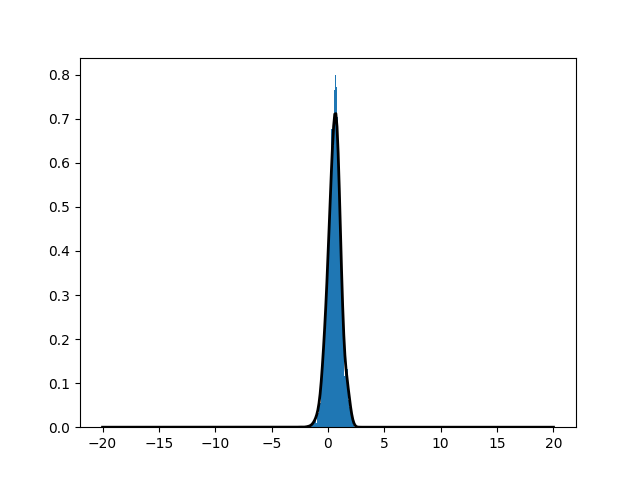

In [15]:
fig, ax = plt.subplots()

_ = ax.hist(obs_n2o, bins=np.linspace(-20,20,401), density=True)
ax.plot(x, kde_values_n2o, 'k-',linewidth=2)
mean_obs_n2o

# N<sub>2</sub>O models

## $\alpha$ prior parameters

In [16]:
ind = ((data_n2o.T_air <= 11) & (data_n2o.T_air >= 9))
n2o_tenC_mean, n2o_tenC_std = ((data_n2o.loc[ind, 'F_N2O_ln']).mean(), (data_n2o.loc[ind, 'F_N2O_ln']).std())

## N<sub>2</sub>O simple model

In [17]:
simple_n2o, idata_simple_n2o = simple_model(T=data_n2o.T_air.values, y=data_n2o.F_N2O_ln.values, alpha_mean=n2o_tenC_mean, alpha_std=n2o_tenC_std,  lambda_beta=1.0, lambda_epsilon=1.0)

Sampling: [alpha, beta, obs, sigma]


In [18]:
obs = data_n2o.loc[:, 'F_N2O_ln']

prior = idata_simple_n2o['prior']
data_inds = np.random.choice(simple_n2o['T_air'].eval().shape[0], size=2000)
pp = {k:np.squeeze(v.to_numpy()) for k,v in prior.items()}
prior_values = simple_model_eq(simple_n2o['T_air'].eval(), pp, data_inds)

In [19]:
simple_kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(prior_values.reshape(-1, 1))

In [20]:
x = np.linspace(-20,20,201).reshape(-1,1)
kde_values = np.exp(simple_kde.score_samples(x))

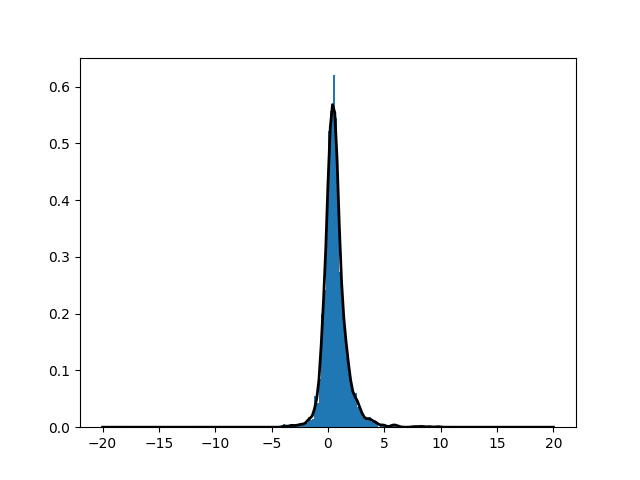

In [21]:
fig, ax = plt.subplots()

_ = ax.hist(prior_values, bins=x.flatten(), density=True)

ax.plot(x, kde_values, 'k-', linewidth=2)

## Local sensitivity of $\sigma_{\gamma}$, $\lambda_{\beta}$ $\lambda_{\delta}$ and $\lambda_{\epsilon}$

In [22]:
gamma_stds = np.linspace(0.1,5,11)
lambda_beta = 1.0
lambda_delta = 1.0
lambda_epsilon = 1.0
fwhms_gamma_std = [[], [], [], [], []]
mean_gamma_std = [[], [], [], [], []]
for i, gamma_std in enumerate(gamma_stds):
    # simple_n2o, idata_simple_n2o = simple_model(T=data_n2o.T_air.values, y=data_n2o.F_N2O_ln.values, alpha_mean=n2o_tenC_mean, alpha_std=n2o_tenC_std,  lambda_beta=lambda_beta, lambda_epsilon=lambda_epsilon)

    full_n2o_st3, idata_full_n2o_st3 = full_model(T=data_n2o.T_air.values, X=st_3_n2o, y = data_n2o.F_N2O_ln.values, alpha_mu_mean=n2o_tenC_mean, alpha_mu_std=n2o_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    full_n2o_st4, idata_full_n2o_st4 = full_model(T=data_n2o.T_air.values, X=st_4_n2o, y = data_n2o.F_N2O_ln.values, alpha_mu_mean=n2o_tenC_mean, alpha_mu_std=n2o_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    full_n2o_st5, idata_full_n2o_st5 = full_model(T=data_n2o.T_air.values, X=st_5_n2o, y = data_n2o.F_N2O_ln.values, alpha_mu_mean=n2o_tenC_mean, alpha_mu_std=n2o_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    full_n2o_st6, idata_full_n2o_st6 = full_model(T=data_n2o.T_air.values, X=st_6_n2o, y = data_n2o.F_N2O_ln.values, alpha_mu_mean=n2o_tenC_mean, alpha_mu_std=n2o_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    full_n2o_st9, idata_full_n2o_st9 = full_model(T=data_n2o.T_air.values, X=st_9_n2o, y = data_n2o.F_N2O_ln.values, alpha_mu_mean=n2o_tenC_mean, alpha_mu_std=n2o_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)

    idatas = [idata_full_n2o_st3, idata_full_n2o_st4, idata_full_n2o_st5, idata_full_n2o_st6, idata_full_n2o_st9]
    models = [full_n2o_st3, full_n2o_st4, full_n2o_st5, full_n2o_st6, full_n2o_st9]
    sts = [st_3_n2o, st_4_n2o, st_5_n2o, st_6_n2o, st_9_n2o]
    cover_or_full = ['full','full','full','full','full','full']
    for j, idata in enumerate(idatas):
        prior = idata['prior']
        data_inds = np.random.choice(sts[j].shape[0], size=2000)
        pp = {k:np.squeeze(v.to_numpy()) for k,v in prior.items()}
        if cover_or_full[j] == 'cover':
            print("There should not be a cover model")
        elif cover_or_full[j] == 'full':
            prior_values = full_model_eq(models[j]['T_air'].eval(), sts[j].values, pp, data_inds)

        kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(prior_values.reshape(-1, 1))
        x = np.linspace(-100,100,10001).reshape(-1,1)
        kde_values = np.exp(kde.score_samples(x))
        fwhm_temp, mean_temp = FWHM(x, kde_values)
        fwhms_gamma_std[j].append(fwhm_temp)
        mean_gamma_std[j].append(mean_temp)


Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, ga

Text(0, 0.5, 'Mean of prior distribution')

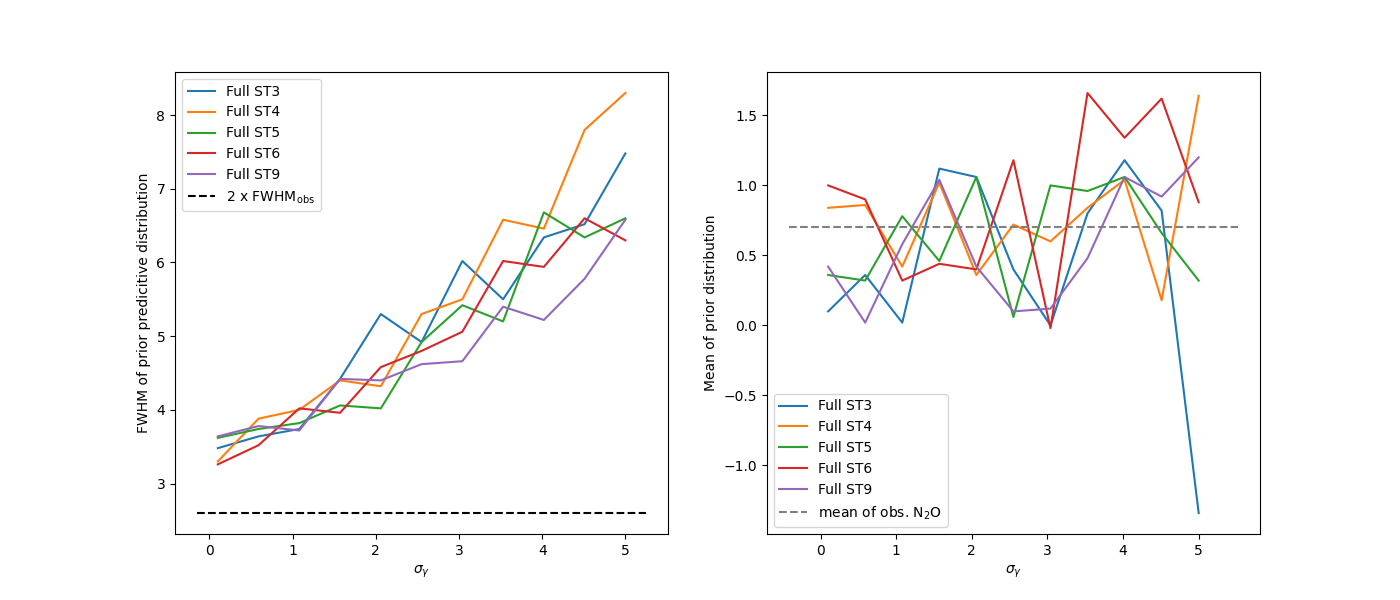

In [23]:
fig, axs = plt.subplots(figsize=(14,6), ncols=2)
axs = axs.flatten()
labels = ['Full ST3','Full ST4','Full ST5', 'Full ST6','Full ST9']
for i in range(5):
    axs[0].plot(gamma_stds, fwhms_gamma_std[i], label=labels[i])

xlims = axs[0].get_xlim()
axs[0].plot((xlims[0], xlims[1]),(2*fwhm_obs_n2o, 2*fwhm_obs_n2o), 'k--', label='2 x FWHM$_{\mathrm{obs}}$')
axs[0].legend()
axs[0].set_xlabel('$\sigma_{\gamma}$')
axs[0].set_ylabel('FWHM of prior predicitive distribution')


for i in range(5):
    axs[1].plot(gamma_stds, mean_gamma_std[i], label=labels[i])

xlims = axs[0].get_xlim()
axs[1].plot((xlims[0], xlims[1]),(mean_obs_n2o, mean_obs_n2o), '--', color='gray', label='mean of obs. N$_2$O')
axs[1].legend()
axs[1].set_xlabel('$\sigma_{\gamma}$')
axs[1].set_ylabel('Mean of prior distribution')

In [24]:
gamma_std = 1.5 #np.linspace(0.1,5,11)
lambda_betas = np.linspace(0.1, 5, 11)
lambda_delta = 1.0
lambda_epsilon = 1.0
fwhms_lambda_beta = [[], [], [], [], [], []]
means_lambda_beta = [[], [], [], [], [], []]
for i, lambda_beta in enumerate(lambda_betas):
    simple_n2o, idata_simple_n2o = simple_model(T=data_n2o.T_air.values, y=data_n2o.F_N2O_ln.values, alpha_mean=n2o_tenC_mean, alpha_std=n2o_tenC_std,  lambda_beta=lambda_beta, lambda_epsilon=lambda_epsilon)
    # cover_n2o_st3, idata_cover_n2o_st3 = cover_model(T=data_n2o.T_air.values, X=st_3_n2o, y = data_n2o.F_N2O_ln.values, gamma_mu_mean=n2o_tenC_mean, gamma_mu_std=n2o_tenC_std, gamma_std=gamma_std, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    #cover_n2o_st5, idata_cover_n2o_st5 = cover_model(T=data_n2o.T_air.values, X=st_5_n2o, y = data_n2o.F_N2O_ln.values, gamma_mu_mean=n2o_tenC_mean, gamma_mu_std=n2o_tenC_std, gamma_std=gamma_std, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
     #cover_n2o_st9, idata_cover_n2o_st9 = cover_model(T=data_n2o.T_air.values, X=st_9_n2o, y = data_n2o.F_N2O_ln.values, gamma_mu_mean=n2o_tenC_mean, gamma_mu_std=n2o_tenC_std, gamma_std=gamma_std, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)

    full_n2o_st3, idata_full_n2o_st3 = full_model(T=data_n2o.T_air.values, X=st_3_n2o, y = data_n2o.F_N2O_ln.values, alpha_mu_mean=n2o_tenC_mean, alpha_mu_std=n2o_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    full_n2o_st4, idata_full_n2o_st4 = full_model(T=data_n2o.T_air.values, X=st_4_n2o, y = data_n2o.F_N2O_ln.values, alpha_mu_mean=n2o_tenC_mean, alpha_mu_std=n2o_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    full_n2o_st5, idata_full_n2o_st5 = full_model(T=data_n2o.T_air.values, X=st_5_n2o, y = data_n2o.F_N2O_ln.values, alpha_mu_mean=n2o_tenC_mean, alpha_mu_std=n2o_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    full_n2o_st6, idata_full_n2o_st6 = full_model(T=data_n2o.T_air.values, X=st_6_n2o, y = data_n2o.F_N2O_ln.values, alpha_mu_mean=n2o_tenC_mean, alpha_mu_std=n2o_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    full_n2o_st9, idata_full_n2o_st9 = full_model(T=data_n2o.T_air.values, X=st_9_n2o, y = data_n2o.F_N2O_ln.values, alpha_mu_mean=n2o_tenC_mean, alpha_mu_std=n2o_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)

    idatas = [idata_simple_n2o, idata_full_n2o_st3, idata_full_n2o_st4, idata_full_n2o_st5, idata_full_n2o_st6, idata_full_n2o_st9]
    models = [simple_n2o, full_n2o_st3, full_n2o_st4, full_n2o_st5, full_n2o_st6, full_n2o_st9]
    sts = [None, st_3_n2o, st_4_n2o, st_5_n2o, st_6_n2o, st_9_n2o]

    for j, idata in enumerate(idatas):
        prior = idata['prior']
        if sts[j] is None:
            data_inds = np.random.choice(simple_n2o['T_air'].eval().shape[0], size=2000)
            pp = {k:np.squeeze(v.to_numpy()) for k,v in prior.items()}
            prior_values = simple_model_eq(simple_n2o['T_air'].eval(), pp, data_inds)
        else:
            data_inds = np.random.choice(sts[j].shape[0], size=2000)
            pp = {k:np.squeeze(v.to_numpy()) for k,v in prior.items()}
            prior_values = full_model_eq(models[j]['T_air'].eval(), sts[j].values, pp, data_inds)

            kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(prior_values.reshape(-1, 1))
            x = np.linspace(-100,100,10001).reshape(-1,1)
            kde_values = np.exp(kde.score_samples(x))
        fwhm_temp, mean_temp = FWHM(x, kde_values)
        fwhms_lambda_beta[j].append(fwhm_temp)
        means_lambda_beta[j].append(mean_temp)


Sampling: [alpha, beta, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs,

Text(0, 0.5, 'Mean of prior predicitive distribution')

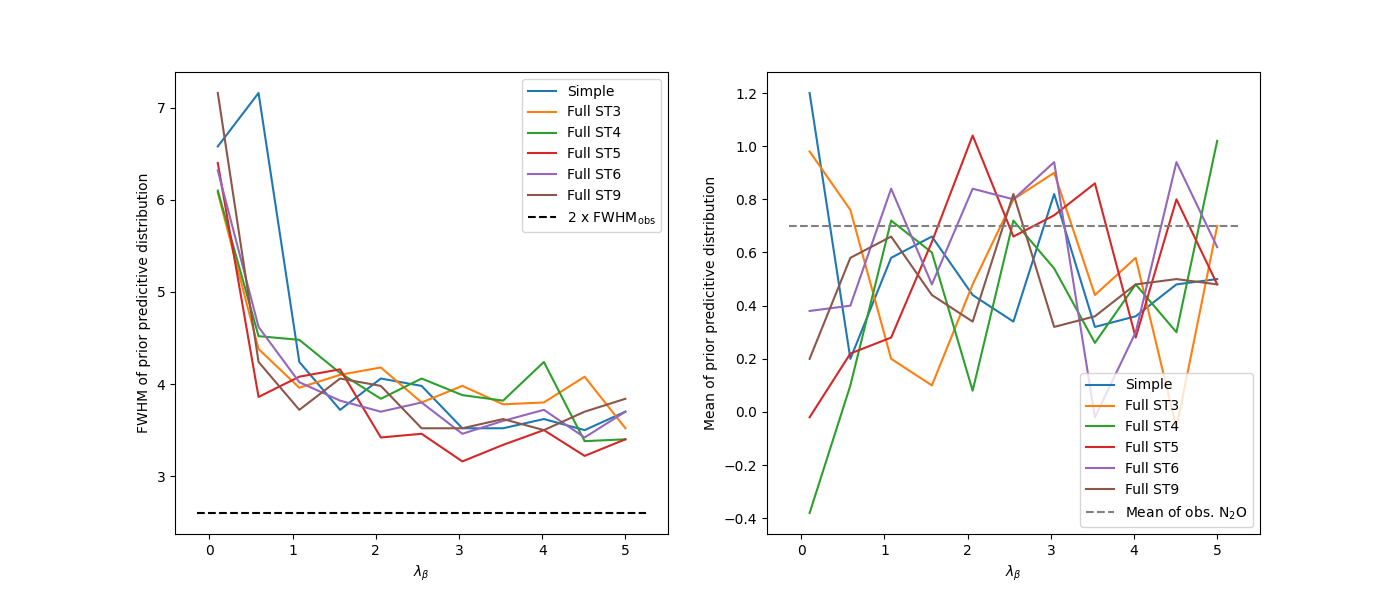

In [25]:
fig, axs = plt.subplots(figsize=(14,6), ncols=2)
axs = axs.flatten()
labels = ['Simple', 'Full ST3','Full ST4', 'Full ST5','Full ST6','Full ST9']
for i in range(len(labels)):
    axs[0].plot(lambda_betas, fwhms_lambda_beta[i], label=labels[i])

xlims = axs[0].get_xlim()
axs[0].plot((xlims[0], xlims[1]),(2*fwhm_obs_n2o, 2*fwhm_obs_n2o), 'k--', label='2 x FWHM$_{\mathrm{obs}}$')
axs[0].legend()
axs[0].set_xlabel(r'$\lambda_{\beta}$')
axs[0].set_ylabel('FWHM of prior predicitive distribution')


for i in range(len(labels)):
    axs[1].plot(lambda_betas, means_lambda_beta[i], label=labels[i])

xlims = axs[1].get_xlim()
axs[1].plot((xlims[0], xlims[1]),(mean_obs_n2o, mean_obs_n2o), '--', color='gray', label='Mean of obs. N$_2$O')
axs[1].legend()
axs[1].set_xlabel(r'$\lambda_{\beta}$')
axs[1].set_ylabel('Mean of prior predicitive distribution')

In [26]:
gamma_std = 1.5 #np.linspace(0.1,5,11)
lambda_beta = 1.0
lambda_deltas = np.linspace(0.1, 5, 11)
lambda_epsilon = 1.0
fwhms_lambda_delta = [[], [], [], [], []]
means_lambda_delta = [[], [], [], [], []]
for i, lambda_delta in enumerate(lambda_deltas):
    # simple_n2o, idata_simple_n2o = simple_model(T=data_n2o.T_air.values, y=data_n2o.F_N2O_ln.values, alpha_mean=n2o_tenC_mean, alpha_std=n2o_tenC_std,  lambda_beta=lambda_beta, lambda_epsilon=lambda_epsilon)
    # cover_n2o_st3, idata_cover_n2o_st3 = cover_model(T=data_n2o.T_air.values, X=st_3_n2o, y = data_n2o.F_N2O_ln.values, gamma_mu_mean=n2o_tenC_mean, gamma_mu_std=n2o_tenC_std, gamma_std=gamma_std, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    # cover_n2o_st5, idata_cover_n2o_st5 = cover_model(T=data_n2o.T_air.values, X=st_5_n2o, y = data_n2o.F_N2O_ln.values, gamma_mu_mean=n2o_tenC_mean, gamma_mu_std=n2o_tenC_std, gamma_std=gamma_std, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    # cover_n2o_st9, idata_cover_n2o_st9 = cover_model(T=data_n2o.T_air.values, X=st_9_n2o, y = data_n2o.F_N2O_ln.values, gamma_mu_mean=n2o_tenC_mean, gamma_mu_std=n2o_tenC_std, gamma_std=gamma_std, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)

    full_n2o_st3, idata_full_n2o_st3 = full_model(T=data_n2o.T_air.values, X=st_3_n2o, y = data_n2o.F_N2O_ln.values, alpha_mu_mean=n2o_tenC_mean, alpha_mu_std=n2o_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    full_n2o_st4, idata_full_n2o_st4 = full_model(T=data_n2o.T_air.values, X=st_4_n2o, y = data_n2o.F_N2O_ln.values, alpha_mu_mean=n2o_tenC_mean, alpha_mu_std=n2o_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    full_n2o_st5, idata_full_n2o_st5 = full_model(T=data_n2o.T_air.values, X=st_5_n2o, y = data_n2o.F_N2O_ln.values, alpha_mu_mean=n2o_tenC_mean, alpha_mu_std=n2o_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    full_n2o_st6, idata_full_n2o_st6 = full_model(T=data_n2o.T_air.values, X=st_6_n2o, y = data_n2o.F_N2O_ln.values, alpha_mu_mean=n2o_tenC_mean, alpha_mu_std=n2o_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    full_n2o_st9, idata_full_n2o_st9 = full_model(T=data_n2o.T_air.values, X=st_9_n2o, y = data_n2o.F_N2O_ln.values, alpha_mu_mean=n2o_tenC_mean, alpha_mu_std=n2o_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)

    idatas = [idata_full_n2o_st3, idata_full_n2o_st4, idata_full_n2o_st5, idata_full_n2o_st6, idata_full_n2o_st9]
    models = [full_n2o_st3, full_n2o_st4, full_n2o_st5, full_n2o_st6, full_n2o_st9]
    sts = [st_3_n2o, st_4_n2o, st_5_n2o, st_6_n2o, st_9_n2o]
    cover_or_full = ['full','full','full','full','full','full']
    for j, idata in enumerate(idatas):
        prior = idata['prior']
        data_inds = np.random.choice(sts[j].shape[0], size=2000)
        pp = {k:np.squeeze(v.to_numpy()) for k,v in prior.items()}
        if cover_or_full[j] == 'cover':
            print("There should not be a cover model")
        elif cover_or_full[j] == 'full':
            prior_values = full_model_eq(models[j]['T_air'].eval(), sts[j].values, pp, data_inds)

        kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(prior_values.reshape(-1, 1))
        x = np.linspace(-100,100,10001).reshape(-1,1)
        kde_values = np.exp(kde.score_samples(x))
        fwhm_temp, mean_temp = FWHM(x, kde_values)
        fwhms_lambda_delta[j].append(fwhm_temp)
        means_lambda_delta[j].append(mean_temp)


Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, ga

Text(0, 0.5, 'Mean of prior predicitive distribution')

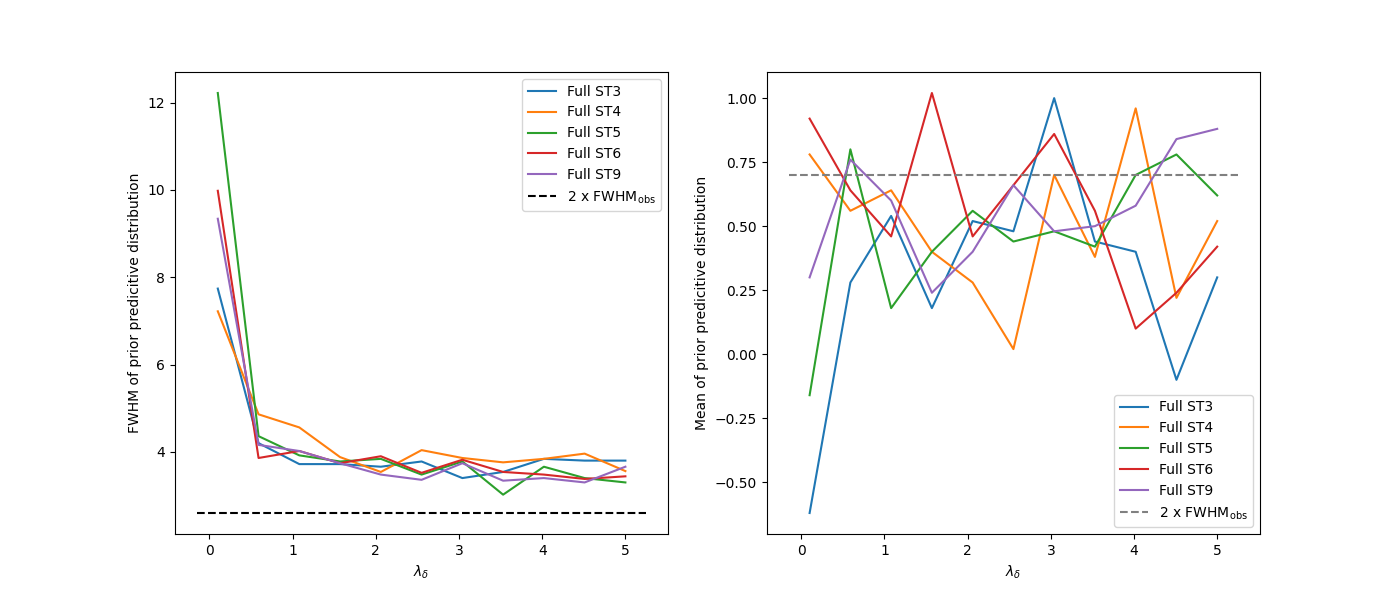

In [27]:
fig, axs = plt.subplots(figsize=(14,6), ncols=2)
axs = axs.flatten()
labels = ['Full ST3','Full ST4','Full ST5','Full ST6','Full ST9']
for i in range(len(labels)):
    axs[0].plot(lambda_deltas, fwhms_lambda_delta[i], label=labels[i])

xlims = axs[0].get_xlim()
axs[0].plot((xlims[0], xlims[1]),(2*fwhm_obs_n2o, 2*fwhm_obs_n2o), 'k--', label='2 x FWHM$_{\mathrm{obs}}$')
axs[0].legend()
axs[0].set_xlabel(r'$\lambda_{\delta}$')
axs[0].set_ylabel('FWHM of prior predicitive distribution')

for i in range(len(labels)):
    axs[1].plot(lambda_deltas, means_lambda_delta[i], label=labels[i])

xlims = axs[1].get_xlim()
axs[1].plot((xlims[0], xlims[1]),(mean_obs_n2o, mean_obs_n2o), '--', color='gray', label='2 x FWHM$_{\mathrm{obs}}$')
axs[1].legend()
axs[1].set_xlabel(r'$\lambda_{\delta}$')
axs[1].set_ylabel('Mean of prior predicitive distribution')

In [28]:
gamma_std = 2.0 #np.linspace(0.1,5,11)
lambda_beta = 1.0
lambda_delta = 1.0
lambda_epsilons = np.linspace(0.1, 5, 11)
fwhms_lambda_epsilon = [[], [], [], [], [], []]
means_lambda_epsilon = [[], [], [], [], [], []]
for i, lambda_epsilon in enumerate(lambda_epsilons):
    simple_n2o, idata_simple_n2o = simple_model(T=data_n2o.T_air.values, y=data_n2o.F_N2O_ln.values, alpha_mean=n2o_tenC_mean, alpha_std=n2o_tenC_std,  lambda_beta=lambda_beta, lambda_epsilon=lambda_epsilon)
    # cover_n2o_st3, idata_cover_n2o_st3 = cover_model(T=data_n2o.T_air.values, X=st_3_n2o, y = data_n2o.F_N2O_ln.values, gamma_mu_mean=n2o_tenC_mean, gamma_mu_std=n2o_tenC_std, gamma_std=gamma_std, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    # cover_n2o_st5, idata_cover_n2o_st5 = cover_model(T=data_n2o.T_air.values, X=st_5_n2o, y = data_n2o.F_N2O_ln.values, gamma_mu_mean=n2o_tenC_mean, gamma_mu_std=n2o_tenC_std, gamma_std=gamma_std, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    # cover_n2o_st9, idata_cover_n2o_st9 = cover_model(T=data_n2o.T_air.values, X=st_9_n2o, y = data_n2o.F_N2O_ln.values, gamma_mu_mean=n2o_tenC_mean, gamma_mu_std=n2o_tenC_std, gamma_std=gamma_std, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    full_n2o_st3, idata_full_n2o_st3 = full_model(T=data_n2o.T_air.values, X=st_3_n2o, y = data_n2o.F_N2O_ln.values, alpha_mu_mean=n2o_tenC_mean, alpha_mu_std=n2o_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    full_n2o_st4, idata_full_n2o_st4 = full_model(T=data_n2o.T_air.values, X=st_4_n2o, y = data_n2o.F_N2O_ln.values, alpha_mu_mean=n2o_tenC_mean, alpha_mu_std=n2o_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    full_n2o_st5, idata_full_n2o_st5 = full_model(T=data_n2o.T_air.values, X=st_5_n2o, y = data_n2o.F_N2O_ln.values, alpha_mu_mean=n2o_tenC_mean, alpha_mu_std=n2o_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    full_n2o_st6, idata_full_n2o_st6 = full_model(T=data_n2o.T_air.values, X=st_6_n2o, y = data_n2o.F_N2O_ln.values, alpha_mu_mean=n2o_tenC_mean, alpha_mu_std=n2o_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    full_n2o_st9, idata_full_n2o_st9 = full_model(T=data_n2o.T_air.values, X=st_9_n2o, y = data_n2o.F_N2O_ln.values, alpha_mu_mean=n2o_tenC_mean, alpha_mu_std=n2o_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)

    idatas = [idata_simple_n2o, idata_full_n2o_st3, idata_full_n2o_st4, idata_full_n2o_st5, idata_full_n2o_st6, idata_full_n2o_st9]
    models = [simple_n2o, full_n2o_st3, full_n2o_st4, full_n2o_st5, full_n2o_st6, full_n2o_st9]
    
    sts = [None, st_3_n2o, st_4_n2o, st_5_n2o, st_6_n2o, st_9_n2o]
    cover_or_full = [None, 'full','full','full','full','full']
    for j, idata in enumerate(idatas):
        prior = idata['prior']
        if sts[j] is None:
            data_inds = np.random.choice(simple_n2o['T_air'].eval().shape[0], size=2000)
            pp = {k:np.squeeze(v.to_numpy()) for k,v in prior.items()}
            prior_values = simple_model_eq(simple_n2o['T_air'].eval(), pp, data_inds)
        else:
            data_inds = np.random.choice(sts[j].shape[0], size=2000)
            pp = {k:np.squeeze(v.to_numpy()) for k,v in prior.items()}
            if cover_or_full[j]=='cover':
                print('There should not be cover model')
            elif cover_or_full[j]=='full':
                prior_values = full_model_eq(models[j]['T_air'].eval(), sts[j].values, pp, data_inds)   

        kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(prior_values.reshape(-1, 1))
        x = np.linspace(-100,100,10001).reshape(-1,1)
        kde_values = np.exp(kde.score_samples(x))
        fwhm_temp, mean_temp = FWHM(x, kde_values)
        fwhms_lambda_epsilon[j].append(fwhm_temp)
        means_lambda_epsilon[j].append(mean_temp)


Sampling: [alpha, beta, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs,

Text(0, 0.5, 'Mean of prior predicitive distribution')

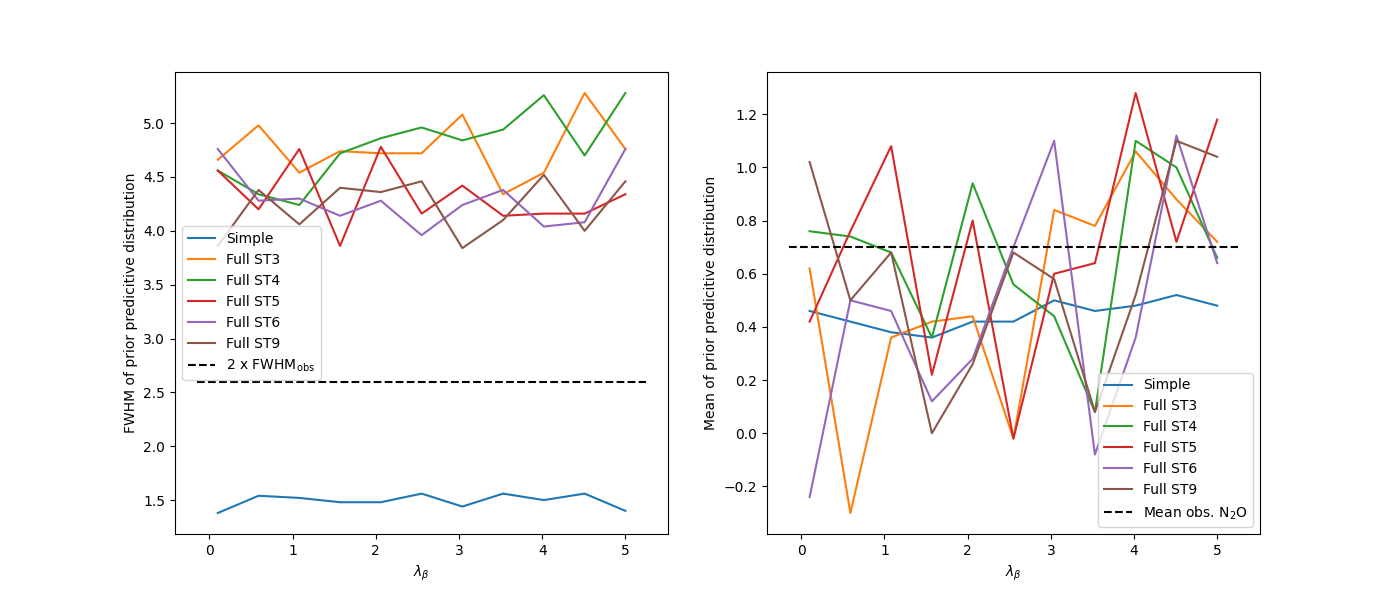

In [29]:
fig, axs = plt.subplots(figsize=(14,6), ncols=2)
axs = axs.flatten()

labels = ['Simple','Full ST3','Full ST4','Full ST5','Full ST6','Full ST9']
for i in range(len(labels)):
    axs[0].plot(lambda_epsilons, fwhms_lambda_epsilon[i], label=labels[i])

xlims = axs[0].get_xlim()
axs[0].plot((xlims[0], xlims[1]),(2*fwhm_obs_n2o, 2*fwhm_obs_n2o), 'k--', label='2 x FWHM$_{\mathrm{obs}}$')
axs[0].legend()
axs[0].set_xlabel(r'$\lambda_{\beta}$')
axs[0].set_ylabel('FWHM of prior predicitive distribution')

for i in range(len(labels)):
    axs[1].plot(lambda_epsilons, means_lambda_epsilon[i], label=labels[i])

xlims = axs[1].get_xlim()
axs[1].plot((xlims[0], xlims[1]),(mean_obs_n2o, mean_obs_n2o), 'k--', label='Mean obs. N$_2$O')
axs[1].legend()
axs[1].set_xlabel(r'$\lambda_{\beta}$')
axs[1].set_ylabel('Mean of prior predicitive distribution')

## Combine figures into one subplot

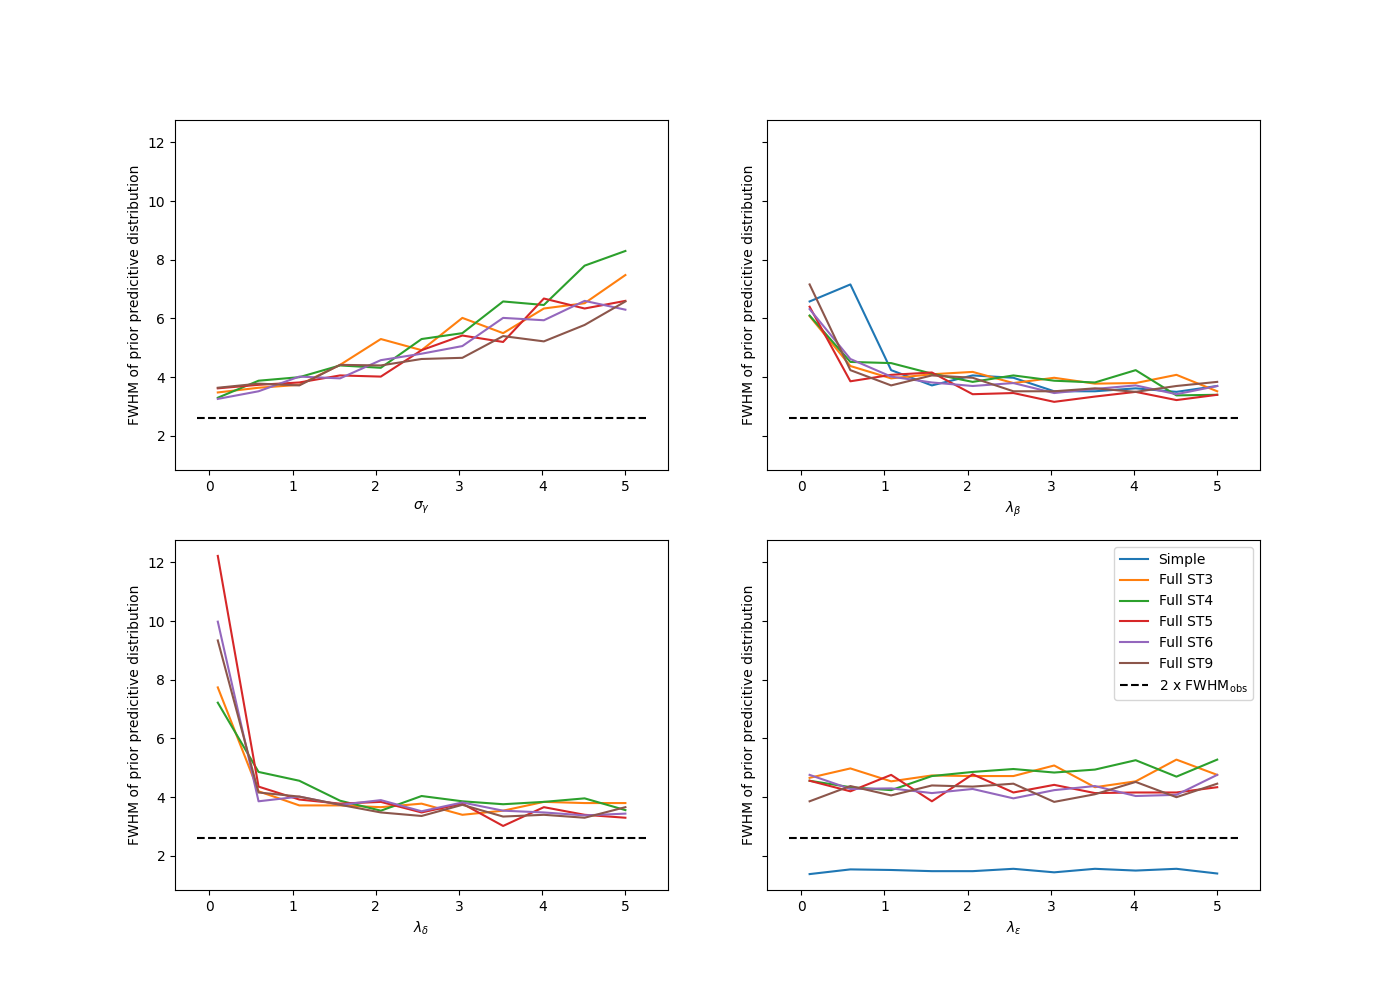

In [30]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14,10), sharey=True)
axs = axs.flatten()
labels = [['Full ST3','Full ST4','Full ST5','Full ST6','Full ST9'],
          ['Simple', 'Full ST3','Full ST4','Full ST5','Full ST6','Full ST9'],
          ['Full ST3','Full ST4','Full ST5','Full ST6','Full ST9'],
          ['Simple','Full ST3','Full ST4','Full ST5','Full ST6','Full ST9'],
          ]
default_colors = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])
colors = [default_colors[1:6],
          default_colors[:6],
          default_colors[1:7],
          default_colors[:7]]
fwhms = [fwhms_gamma_std, fwhms_lambda_beta, fwhms_lambda_delta, fwhms_lambda_epsilon]
xlabels = [r'$\sigma_{\gamma}$',r'$\lambda_{\beta}$',r'$\lambda_{\delta}$',r'$\lambda_{\epsilon}$']
x_axis_values = [gamma_stds, lambda_betas, lambda_deltas, lambda_epsilons]
for i, ax in enumerate(axs):
    for j in range(len(fwhms[i])):
        ax.plot(x_axis_values[i], fwhms[i][j], label=labels[i][j], color=colors[i][j])

    xlims = ax.get_xlim()
    ax.plot((xlims[0], xlims[1]),(2*fwhm_obs_n2o, 2*fwhm_obs_n2o), 'k--', label='2 x FWHM$_{\mathrm{obs}}$')
    if i==3:
        ax.legend()

    ax.set_xlabel(xlabels[i])
    ax.set_ylabel('FWHM of prior predicitive distribution')

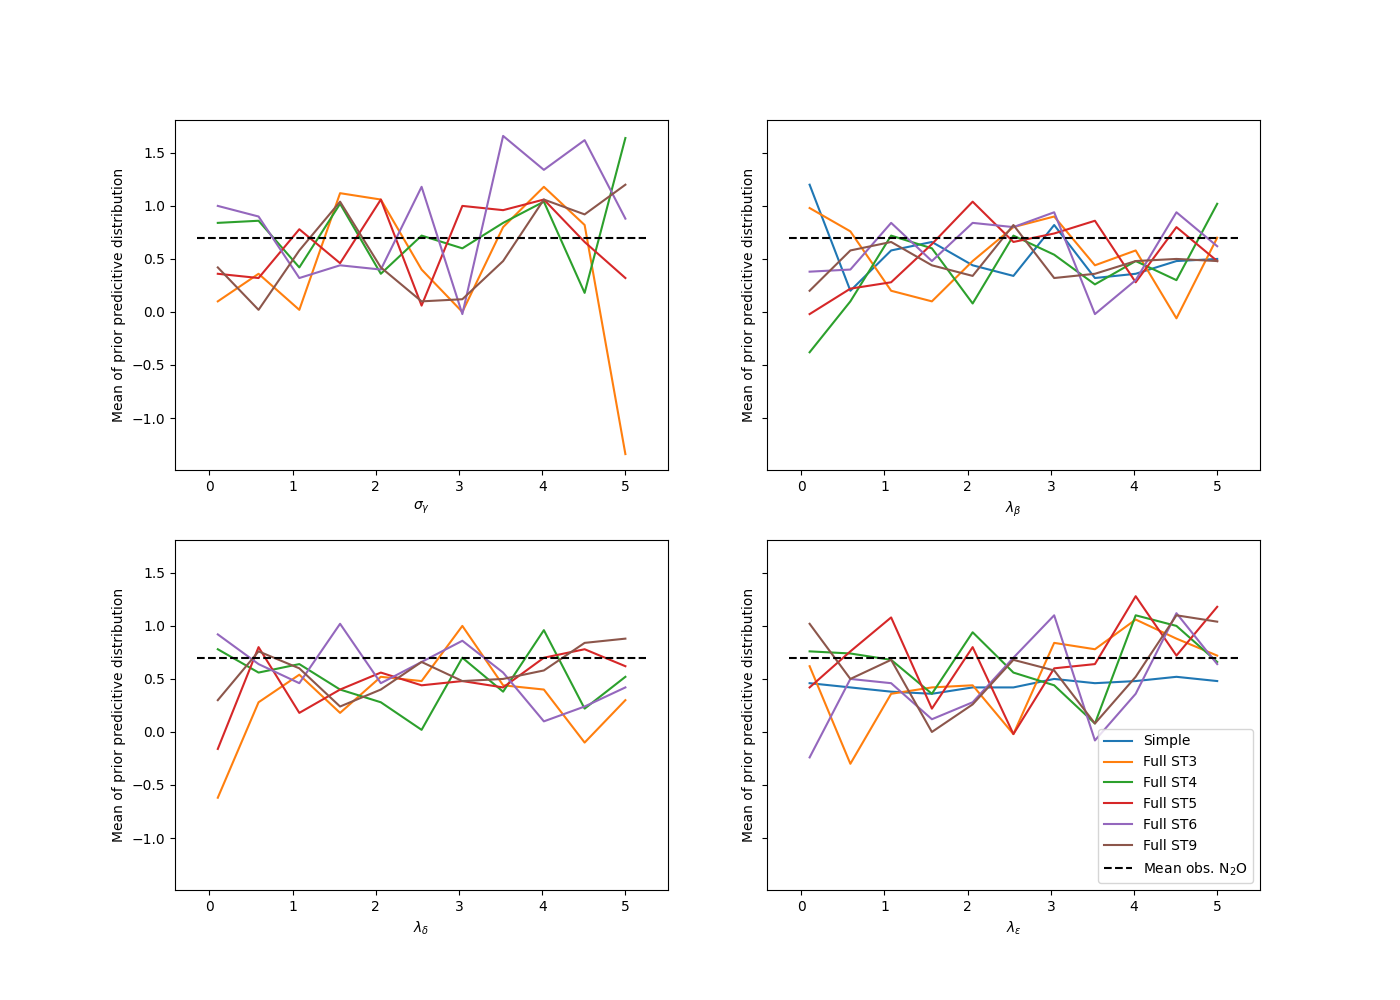

In [31]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14,10), sharey=True)
axs = axs.flatten()
labels = [['Full ST3','Full ST4','Full ST5','Full ST6','Full ST9'],
          ['Simple', 'Full ST3','Full ST4','Full ST5','Full ST6','Full ST9'],
          ['Full ST3','Full ST4','Full ST5','Full ST6','Full ST9'],
          ['Simple','Full ST3','Full ST4','Full ST5','Full ST6','Full ST9'],
          ]
default_colors = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])
colors = [default_colors[1:6],
          default_colors[:6],
          default_colors[1:7],
          default_colors[:7]]
means = [mean_gamma_std, means_lambda_beta, means_lambda_delta, means_lambda_epsilon]
xlabels = [r'$\sigma_{\gamma}$',r'$\lambda_{\beta}$',r'$\lambda_{\delta}$',r'$\lambda_{\epsilon}$']
x_axis_values = [gamma_stds, lambda_betas, lambda_deltas, lambda_epsilons]
for i, ax in enumerate(axs):
    for j in range(len(means[i])):
        ax.plot(x_axis_values[i], means[i][j], label=labels[i][j], color=colors[i][j])

    xlims = ax.get_xlim()
    ax.plot((xlims[0], xlims[1]),(mean_obs_n2o, mean_obs_n2o), 'k--', label='Mean obs. N$_2$O')
    if i==3:
        ax.legend()

    ax.set_xlabel(xlabels[i])
    ax.set_ylabel('Mean of prior predicitive distribution')

## Choose values
These values are used in the notebook [GHG_models_fit.ipynb](GHG_models_fit.ipynb)
$$
\begin{align*}
\sigma_\gamma = 2.0 \\
\lambda_\beta = 1.0 \\
\lambda_\delta = 1.0 \\
\lambda_\epsilon = 1.0
\end{align*}
$$

## Plot prior predicitive distributions

In [32]:
def plot_prior_predictive(obs, prior_values, xlabel, ax, title=''):
    fs=16
    ls=14
    bins, counts, _ = ax.hist(obs, bins=100, color='goldenrod', density=True, label=f'Measured {xlabel}')
    bins, counts, _ = ax.hist(prior_values, bins = np.linspace(-100,100,10001), alpha=0.75, density=True, label='Prior')

    ax.legend(loc='best')
    ax.tick_params(axis='both', labelsize=ls)
    ax.set_title(title, fontsize=fs)

    kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(obs.reshape(-1, 1))
    x = np.linspace(-100,100,10001).reshape(-1,1)
    kde_values = np.exp(kde.score_samples(x))
    fwhm_obs, mean_obs = FWHM(x, kde_values)


    obs_max_x = x[np.argmax(kde_values)]
    xmax = obs_max_x + 5*fwhm_obs
    xmin = obs_max_x - 5*fwhm_obs
    ax.set_xlim([xmin, xmax])

    kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(prior_values.reshape(-1, 1))
    kde_values = np.exp(kde.score_samples(x))
    fwhm_model, mean_model = FWHM(x, kde_values)

    # ymin, ymax = ax.get_ylim()
    # xmin, xmax = ax.get_xlim()
    ax.text(0.05, 0.75, f'FWHM$_{{\mathrm{{model}}}}: {np.round(fwhm_model,2)}$', transform=ax.transAxes)
    ax.text(0.05, 0.7, f'FWHM$_{{\mathrm{{obs}}}}: {np.round(fwhm_obs,2)}$', transform=ax.transAxes)
    ax.text(0.05, 0.65, f'$\mu_{{\mathrm{{model}}}}: {np.round(mean_model,2)}$',transform=ax.transAxes)
    ax.text(0.05, 0.6, f'$\mu_{{\mathrm{{obs}}}}: {np.round(mean_obs,2)}$', transform=ax.transAxes)


Sampling: [alpha, beta, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]


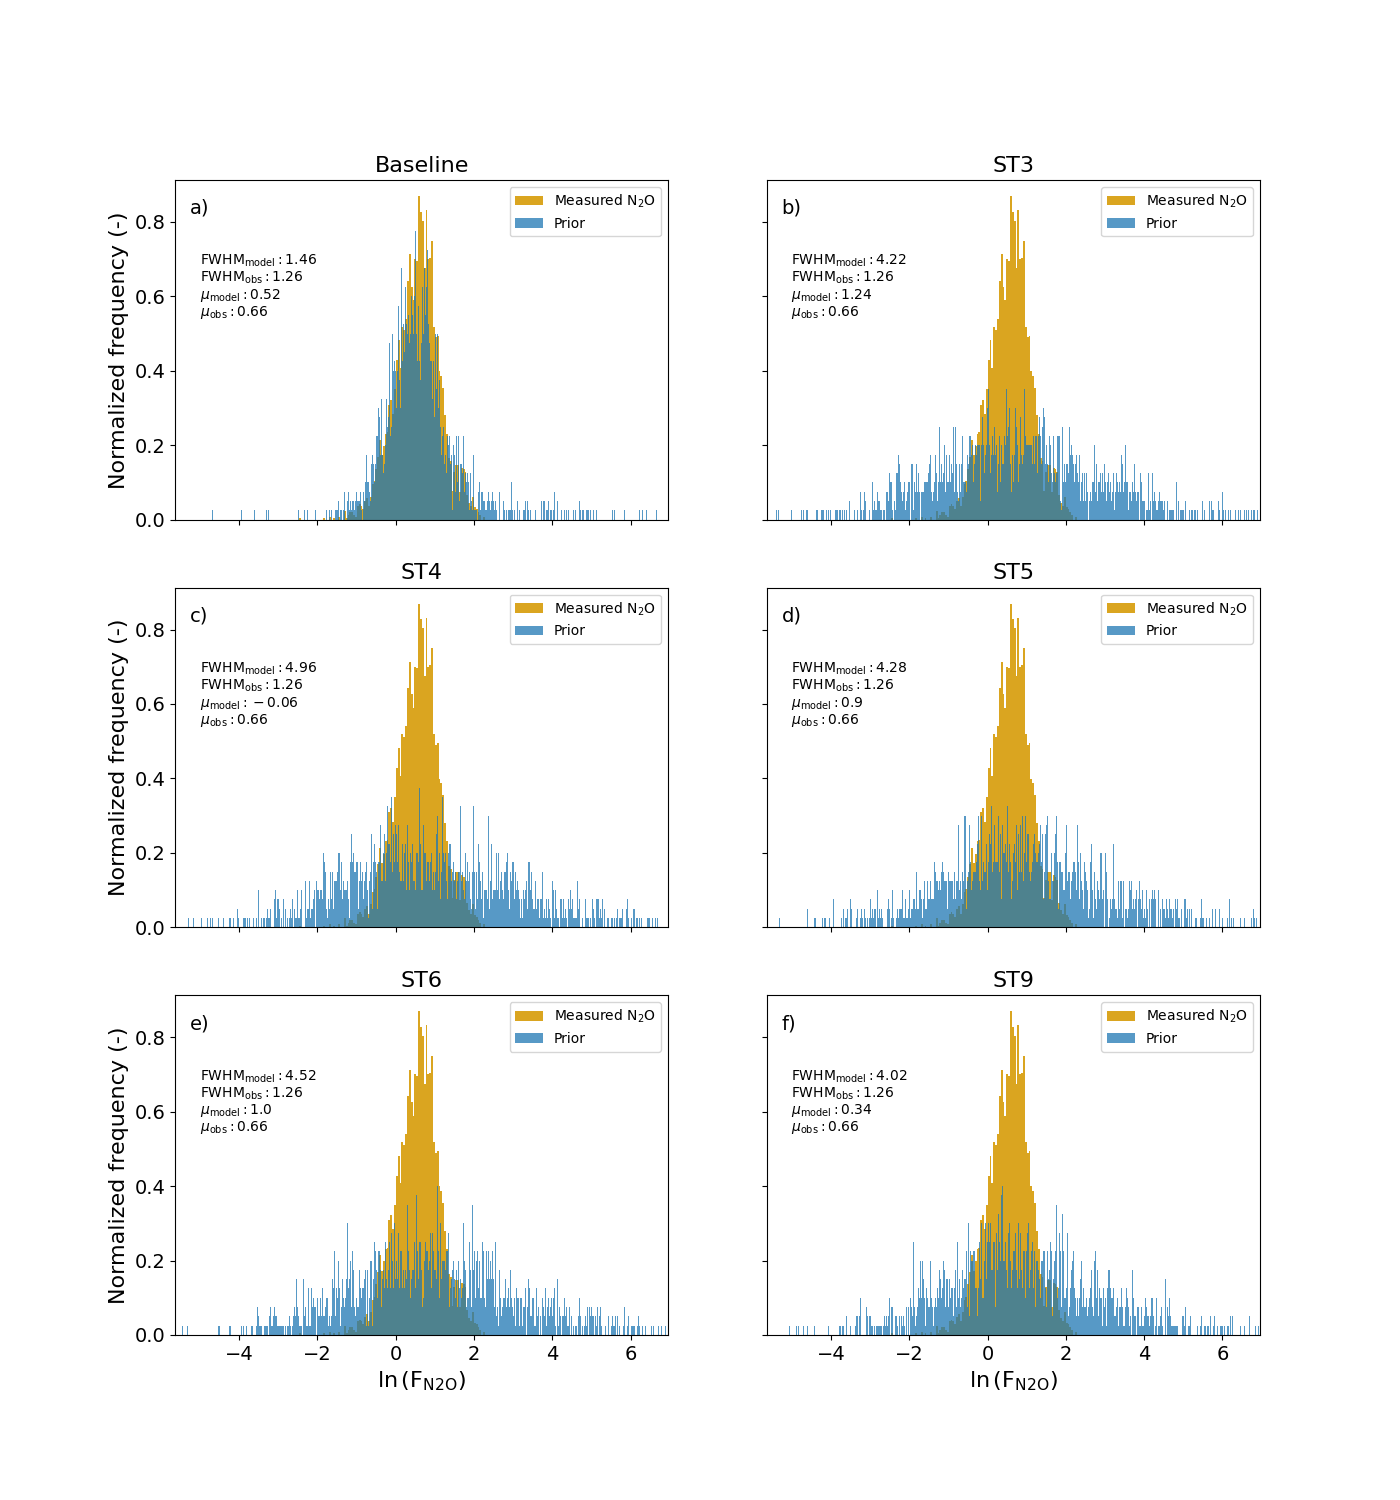

In [187]:
fig, axs = plt.subplots(figsize=(14,15), nrows=3, ncols=2, sharex=True, sharey=True)
axs = axs.flatten()
sigma_gamma = 2.0
lambda_beta = 1.0
lambda_delta = 1.0
lambda_epsilon=1.0

simple_n2o, idata_simple_n2o = simple_model(T=data_n2o.T_air.values, y=data_n2o.F_N2O_ln.values, alpha_mean=n2o_tenC_mean, alpha_std=n2o_tenC_std,  lambda_beta=lambda_beta, lambda_epsilon=lambda_epsilon)
# cover_n2o_st3, idata_cover_n2o_st3 = cover_model(T=data_n2o.T_air.values, X=st_3_n2o, y = data_n2o.F_N2O_ln.values, gamma_mu_mean=n2o_tenC_mean, gamma_mu_std=n2o_tenC_std, gamma_std=sigma_gamma, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
# cover_n2o_st5, idata_cover_n2o_st5 = cover_model(T=data_n2o.T_air.values, X=st_5_n2o, y = data_n2o.F_N2O_ln.values, gamma_mu_mean=n2o_tenC_mean, gamma_mu_std=n2o_tenC_std, gamma_std=sigma_gamma, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
# cover_n2o_st9, idata_cover_n2o_st9 = cover_model(T=data_n2o.T_air.values, X=st_9_n2o, y = data_n2o.F_N2O_ln.values, gamma_mu_mean=n2o_tenC_mean, gamma_mu_std=n2o_tenC_std, gamma_std=sigma_gamma, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)

full_n2o_st3, idata_full_n2o_st3 = full_model(T=data_n2o.T_air.values, X=st_3_n2o, y = data_n2o.F_N2O_ln.values, alpha_mu_mean=n2o_tenC_mean, alpha_mu_std=n2o_tenC_std, gamma_std=sigma_gamma, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
full_n2o_st4, idata_full_n2o_st4 = full_model(T=data_n2o.T_air.values, X=st_4_n2o, y = data_n2o.F_N2O_ln.values, alpha_mu_mean=n2o_tenC_mean, alpha_mu_std=n2o_tenC_std, gamma_std=sigma_gamma, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
full_n2o_st5, idata_full_n2o_st5 = full_model(T=data_n2o.T_air.values, X=st_5_n2o, y = data_n2o.F_N2O_ln.values, alpha_mu_mean=n2o_tenC_mean, alpha_mu_std=n2o_tenC_std, gamma_std=sigma_gamma, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
full_n2o_st6, idata_full_n2o_st6 = full_model(T=data_n2o.T_air.values, X=st_6_n2o, y = data_n2o.F_N2O_ln.values, alpha_mu_mean=n2o_tenC_mean, alpha_mu_std=n2o_tenC_std, gamma_std=sigma_gamma, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
full_n2o_st9, idata_full_n2o_st9 = full_model(T=data_n2o.T_air.values, X=st_9_n2o, y = data_n2o.F_N2O_ln.values, alpha_mu_mean=n2o_tenC_mean, alpha_mu_std=n2o_tenC_std, gamma_std=sigma_gamma, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)

idatas = [idata_simple_n2o, idata_full_n2o_st3, idata_full_n2o_st4, idata_full_n2o_st5, idata_full_n2o_st6, idata_full_n2o_st9]
models = [simple_n2o, full_n2o_st3, full_n2o_st4, full_n2o_st5, full_n2o_st6, full_n2o_st9]
sts = [None, st_3_n2o, st_4_n2o, st_5_n2o, st_6_n2o, st_9_n2o]
full_or_cover = [None, 'full','full', 'full', 'full','full']
titles = ['Baseline','ST3','ST4','ST5','ST6','ST9']
subplot_labels = ['a)','b)','c)','d)','e)','f)']
for i, idata in enumerate(idatas):
    prior = idata['prior']
    if sts[i] is None:
        data_inds = np.random.choice(simple_n2o['T_air'].eval().shape[0], size=2000)
        pp = {k:np.squeeze(v.to_numpy()) for k,v in prior.items()}
        prior_values = simple_model_eq(simple_n2o['T_air'].eval(), pp, data_inds)
    else:
        data_inds = np.random.choice(sts[i].shape[0], size=2000)
        pp = {k:np.squeeze(v.to_numpy()) for k,v in prior.items()}
        if full_or_cover[i] == 'cover':
            print('There should not be a cover model')
        elif full_or_cover[i] == 'full':
            prior_values = full_model_eq(models[i]['T_air'].eval(), sts[i].values, pp, data_inds)

    plot_prior_predictive(obs_n2o, prior_values, 'N$_2$O', ax=axs[i], title=titles[i])

    if i==4 or i==5:
        axs[i].set_xlabel('$\ln{(\mathrm{F}_\mathrm{N2O})}$', fontsize=16)
    if i==0 or i==2 or i==4:
        axs[i].set_ylabel('Normalized frequency (-)', fontsize=16)
    axs[i].text(0.03, 0.9, subplot_labels[i], transform=axs[i].transAxes, fontsize=14)

    

# for ax in axs[-2:]:
#     ax.remove()

# CH<sub>4</sub> models

## $\alpha$ prior parameters

In [188]:
ind = ((data_ch4.T_air <= 11) & (data_ch4.T_air >= 9))
ch4_tenC_mean, ch4_tenC_std = ((data_ch4.loc[ind, 'F_CH4_ln']).mean(), (data_ch4.loc[ind, 'F_CH4_ln']).std())

## CH<sub>4</sub> simple model

In [189]:
simple_ch4, idata_simple_ch4 = simple_model(T=data_ch4.T_air.values, y=data_ch4.F_CH4_ln.values, alpha_mean=ch4_tenC_mean, alpha_std=ch4_tenC_std,  lambda_beta=1.0, lambda_epsilon=1.0)

Sampling: [alpha, beta, obs, sigma]


In [190]:
obs = data_ch4.loc[:, 'F_CH4_ln']

prior = idata_simple_ch4['prior']
data_inds = np.random.choice(simple_ch4['T_air'].eval().shape[0], size=2000)
pp = {k:np.squeeze(v.to_numpy()) for k,v in prior.items()}
prior_values = simple_model_eq(simple_ch4['T_air'].eval(), pp, data_inds)

In [191]:
simple_kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(prior_values.reshape(-1, 1))

In [192]:
x = np.linspace(-20,0,101).reshape(-1,1)
kde_values = np.exp(simple_kde.score_samples(x))

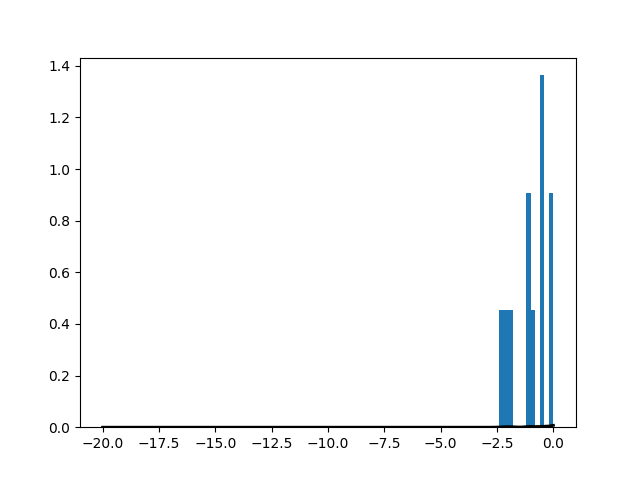

In [193]:
fig, ax = plt.subplots()

_ = ax.hist(prior_values, bins=x.flatten(), density=True)

ax.plot(x, kde_values, 'k-', linewidth=2)

## Local sensitivity of $\sigma_{\gamma}$, $\lambda_{\beta}$ $\lambda_{\delta}$ and $\lambda_{\epsilon}$

In [194]:
gamma_stds = np.linspace(0.1,5,11)
lambda_beta = 1.0
lambda_delta = 1.0
lambda_epsilon = 1.0
fwhms_gamma_std = [[], [], [], [], []]
mean_gamma_std = [[], [], [], [], []]
for i, gamma_std in enumerate(gamma_stds):
    # simple_ch4, idata_simple_ch4 = simple_model(T=data_ch4.T_air.values, y=data_ch4.F_CH4_ln.values, alpha_mean=ch4_tenC_mean, alpha_std=ch4_tenC_std,  lambda_beta=lambda_beta, lambda_epsilon=lambda_epsilon)

    full_ch4_st3, idata_full_ch4_st3 = full_model(T=data_ch4.T_air.values, X=st_3_ch4, y = data_ch4.F_CH4_ln.values, alpha_mu_mean=ch4_tenC_mean, alpha_mu_std=ch4_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    full_ch4_st4, idata_full_ch4_st4 = full_model(T=data_ch4.T_air.values, X=st_4_ch4, y = data_ch4.F_CH4_ln.values, alpha_mu_mean=ch4_tenC_mean, alpha_mu_std=ch4_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    full_ch4_st5, idata_full_ch4_st5 = full_model(T=data_ch4.T_air.values, X=st_5_ch4, y = data_ch4.F_CH4_ln.values, alpha_mu_mean=ch4_tenC_mean, alpha_mu_std=ch4_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    full_ch4_st6, idata_full_ch4_st6 = full_model(T=data_ch4.T_air.values, X=st_6_ch4, y = data_ch4.F_CH4_ln.values, alpha_mu_mean=ch4_tenC_mean, alpha_mu_std=ch4_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    full_ch4_st9, idata_full_ch4_st9 = full_model(T=data_ch4.T_air.values, X=st_9_ch4, y = data_ch4.F_CH4_ln.values, alpha_mu_mean=ch4_tenC_mean, alpha_mu_std=ch4_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)

    idatas = [idata_full_ch4_st3, idata_full_ch4_st4, idata_full_ch4_st5, idata_full_ch4_st6, idata_full_ch4_st9]
    models = [full_ch4_st3, full_ch4_st4, full_ch4_st5, full_ch4_st6, full_ch4_st9]
    sts = [st_3_ch4, st_4_ch4, st_5_ch4, st_6_ch4, st_9_ch4]
    cover_or_full = ['full','full','full','full','full','full']
    for j, idata in enumerate(idatas):
        prior = idata['prior']
        data_inds = np.random.choice(sts[j].shape[0], size=2000)
        pp = {k:np.squeeze(v.to_numpy()) for k,v in prior.items()}
        if cover_or_full[j] == 'cover':
            print("There should not be a cover model")
        elif cover_or_full[j] == 'full':
            prior_values = full_model_eq(models[j]['T_air'].eval(), sts[j].values, pp, data_inds)

        kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(prior_values.reshape(-1, 1))
        x = np.linspace(-100,100,10001).reshape(-1,1)
        kde_values = np.exp(kde.score_samples(x))
        fwhm_temp, mean_temp = FWHM(x, kde_values)
        fwhms_gamma_std[j].append(fwhm_temp)
        mean_gamma_std[j].append(mean_temp)


Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, ga

Text(0, 0.5, 'Mean of prior distribution')

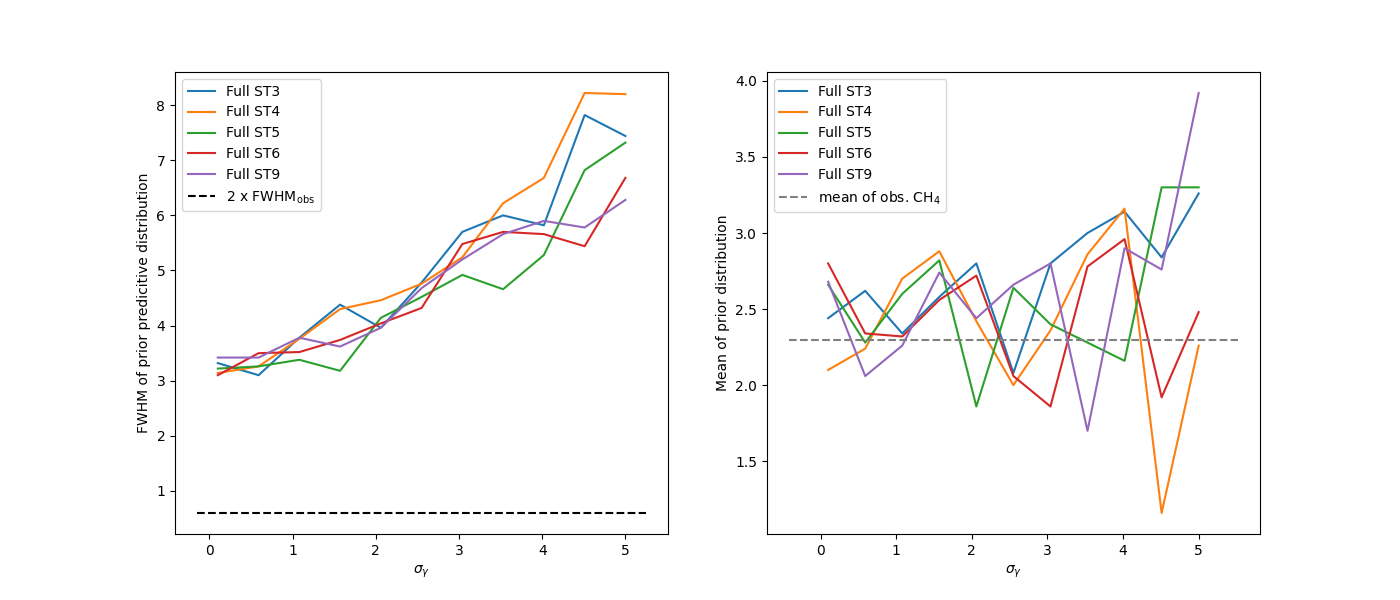

In [195]:
fig, axs = plt.subplots(figsize=(14,6), ncols=2)
axs = axs.flatten()
labels = ['Full ST3','Full ST4','Full ST5', 'Full ST6','Full ST9']
for i in range(5):
    axs[0].plot(gamma_stds, fwhms_gamma_std[i], label=labels[i])

xlims = axs[0].get_xlim()
axs[0].plot((xlims[0], xlims[1]),(2*fwhm_obs_ch4, 2*fwhm_obs_ch4), 'k--', label='2 x FWHM$_{\mathrm{obs}}$')
axs[0].legend()
axs[0].set_xlabel('$\sigma_{\gamma}$')
axs[0].set_ylabel('FWHM of prior predicitive distribution')


for i in range(5):
    axs[1].plot(gamma_stds, mean_gamma_std[i], label=labels[i])

xlims = axs[0].get_xlim()
axs[1].plot((xlims[0], xlims[1]),(mean_obs_ch4, mean_obs_ch4), '--', color='gray', label='mean of obs. CH$_4$')
axs[1].legend()
axs[1].set_xlabel('$\sigma_{\gamma}$')
axs[1].set_ylabel('Mean of prior distribution')

In [196]:
gamma_std = 1.5 #np.linspace(0.1,5,11)
lambda_betas = np.linspace(0.1, 5, 11)
lambda_delta = 1.0
lambda_epsilon = 1.0
fwhms_lambda_beta = [[], [], [], [], [], []]
means_lambda_beta = [[], [], [], [], [], []]
for i, lambda_beta in enumerate(lambda_betas):
    simple_ch4, idata_simple_ch4 = simple_model(T=data_ch4.T_air.values, y=data_ch4.F_CH4_ln.values, alpha_mean=ch4_tenC_mean, alpha_std=ch4_tenC_std,  lambda_beta=lambda_beta, lambda_epsilon=lambda_epsilon)
    # cover_ch4_st3, idata_cover_ch4_st3 = cover_model(T=data_ch4.T_air.values, X=st_3_ch4, y = data_ch4.F_CH4_ln.values, gamma_mu_mean=ch4_tenC_mean, gamma_mu_std=ch4_tenC_std, gamma_std=gamma_std, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    #cover_ch4_st5, idata_cover_ch4_st5 = cover_model(T=data_ch4.T_air.values, X=st_5_ch4, y = data_ch4.F_CH4_ln.values, gamma_mu_mean=ch4_tenC_mean, gamma_mu_std=ch4_tenC_std, gamma_std=gamma_std, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
     #cover_ch4_st9, idata_cover_ch4_st9 = cover_model(T=data_ch4.T_air.values, X=st_9_ch4, y = data_ch4.F_CH4_ln.values, gamma_mu_mean=ch4_tenC_mean, gamma_mu_std=ch4_tenC_std, gamma_std=gamma_std, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)

    full_ch4_st3, idata_full_ch4_st3 = full_model(T=data_ch4.T_air.values, X=st_3_ch4, y = data_ch4.F_CH4_ln.values, alpha_mu_mean=ch4_tenC_mean, alpha_mu_std=ch4_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    full_ch4_st4, idata_full_ch4_st4 = full_model(T=data_ch4.T_air.values, X=st_4_ch4, y = data_ch4.F_CH4_ln.values, alpha_mu_mean=ch4_tenC_mean, alpha_mu_std=ch4_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    full_ch4_st5, idata_full_ch4_st5 = full_model(T=data_ch4.T_air.values, X=st_5_ch4, y = data_ch4.F_CH4_ln.values, alpha_mu_mean=ch4_tenC_mean, alpha_mu_std=ch4_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    full_ch4_st6, idata_full_ch4_st6 = full_model(T=data_ch4.T_air.values, X=st_6_ch4, y = data_ch4.F_CH4_ln.values, alpha_mu_mean=ch4_tenC_mean, alpha_mu_std=ch4_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    full_ch4_st9, idata_full_ch4_st9 = full_model(T=data_ch4.T_air.values, X=st_9_ch4, y = data_ch4.F_CH4_ln.values, alpha_mu_mean=ch4_tenC_mean, alpha_mu_std=ch4_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)

    idatas = [idata_simple_ch4, idata_full_ch4_st3, idata_full_ch4_st4, idata_full_ch4_st5, idata_full_ch4_st6, idata_full_ch4_st9]
    models = [simple_ch4, full_ch4_st3, full_ch4_st4, full_ch4_st5, full_ch4_st6, full_ch4_st9]
    sts = [None, st_3_ch4, st_4_ch4, st_5_ch4, st_6_ch4, st_9_ch4]

    for j, idata in enumerate(idatas):
        prior = idata['prior']
        if sts[j] is None:
            data_inds = np.random.choice(simple_ch4['T_air'].eval().shape[0], size=2000)
            pp = {k:np.squeeze(v.to_numpy()) for k,v in prior.items()}
            prior_values = simple_model_eq(simple_ch4['T_air'].eval(), pp, data_inds)
        else:
            data_inds = np.random.choice(sts[j].shape[0], size=2000)
            pp = {k:np.squeeze(v.to_numpy()) for k,v in prior.items()}
            prior_values = full_model_eq(models[j]['T_air'].eval(), sts[j].values, pp, data_inds)

            kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(prior_values.reshape(-1, 1))
            x = np.linspace(-100,100,10001).reshape(-1,1)
            kde_values = np.exp(kde.score_samples(x))
        fwhm_temp, mean_temp = FWHM(x, kde_values)
        fwhms_lambda_beta[j].append(fwhm_temp)
        means_lambda_beta[j].append(mean_temp)


Sampling: [alpha, beta, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs,

Text(0, 0.5, 'Mean of prior predicitive distribution')

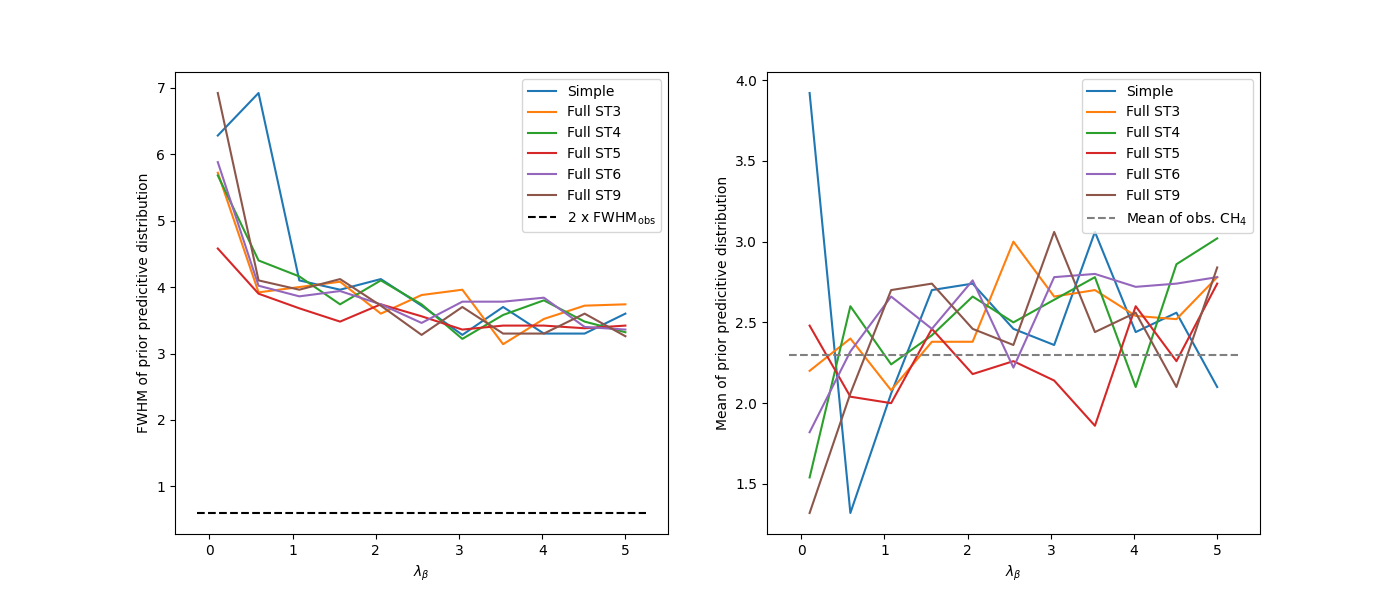

In [197]:
fig, axs = plt.subplots(figsize=(14,6), ncols=2)
axs = axs.flatten()
labels = ['Simple', 'Full ST3','Full ST4', 'Full ST5','Full ST6','Full ST9']
for i in range(len(labels)):
    axs[0].plot(lambda_betas, fwhms_lambda_beta[i], label=labels[i])

xlims = axs[0].get_xlim()
axs[0].plot((xlims[0], xlims[1]),(2*fwhm_obs_ch4, 2*fwhm_obs_ch4), 'k--', label='2 x FWHM$_{\mathrm{obs}}$')
axs[0].legend()
axs[0].set_xlabel(r'$\lambda_{\beta}$')
axs[0].set_ylabel('FWHM of prior predicitive distribution')


for i in range(len(labels)):
    axs[1].plot(lambda_betas, means_lambda_beta[i], label=labels[i])

xlims = axs[1].get_xlim()
axs[1].plot((xlims[0], xlims[1]),(mean_obs_ch4, mean_obs_ch4), '--', color='gray', label='Mean of obs. CH$_4$')
axs[1].legend()
axs[1].set_xlabel(r'$\lambda_{\beta}$')
axs[1].set_ylabel('Mean of prior predicitive distribution')

In [198]:
gamma_std = 1.5 #np.linspace(0.1,5,11)
lambda_beta = 1.0
lambda_deltas = np.linspace(0.1, 5, 11)
lambda_epsilon = 1.0
fwhms_lambda_delta = [[], [], [], [], []]
means_lambda_delta = [[], [], [], [], []]
for i, lambda_delta in enumerate(lambda_deltas):
    # simple_ch4, idata_simple_ch4 = simple_model(T=data_ch4.T_air.values, y=data_ch4.F_CH4_ln.values, alpha_mean=ch4_tenC_mean, alpha_std=ch4_tenC_std,  lambda_beta=lambda_beta, lambda_epsilon=lambda_epsilon)
    # cover_ch4_st3, idata_cover_ch4_st3 = cover_model(T=data_ch4.T_air.values, X=st_3_ch4, y = data_ch4.F_CH4_ln.values, gamma_mu_mean=ch4_tenC_mean, gamma_mu_std=ch4_tenC_std, gamma_std=gamma_std, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    # cover_ch4_st5, idata_cover_ch4_st5 = cover_model(T=data_ch4.T_air.values, X=st_5_ch4, y = data_ch4.F_CH4_ln.values, gamma_mu_mean=ch4_tenC_mean, gamma_mu_std=ch4_tenC_std, gamma_std=gamma_std, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    # cover_ch4_st9, idata_cover_ch4_st9 = cover_model(T=data_ch4.T_air.values, X=st_9_ch4, y = data_ch4.F_CH4_ln.values, gamma_mu_mean=ch4_tenC_mean, gamma_mu_std=ch4_tenC_std, gamma_std=gamma_std, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)

    full_ch4_st3, idata_full_ch4_st3 = full_model(T=data_ch4.T_air.values, X=st_3_ch4, y = data_ch4.F_CH4_ln.values, alpha_mu_mean=ch4_tenC_mean, alpha_mu_std=ch4_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    full_ch4_st4, idata_full_ch4_st4 = full_model(T=data_ch4.T_air.values, X=st_4_ch4, y = data_ch4.F_CH4_ln.values, alpha_mu_mean=ch4_tenC_mean, alpha_mu_std=ch4_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    full_ch4_st5, idata_full_ch4_st5 = full_model(T=data_ch4.T_air.values, X=st_5_ch4, y = data_ch4.F_CH4_ln.values, alpha_mu_mean=ch4_tenC_mean, alpha_mu_std=ch4_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    full_ch4_st6, idata_full_ch4_st6 = full_model(T=data_ch4.T_air.values, X=st_6_ch4, y = data_ch4.F_CH4_ln.values, alpha_mu_mean=ch4_tenC_mean, alpha_mu_std=ch4_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    full_ch4_st9, idata_full_ch4_st9 = full_model(T=data_ch4.T_air.values, X=st_9_ch4, y = data_ch4.F_CH4_ln.values, alpha_mu_mean=ch4_tenC_mean, alpha_mu_std=ch4_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)

    idatas = [idata_full_ch4_st3, idata_full_ch4_st4, idata_full_ch4_st5, idata_full_ch4_st6, idata_full_ch4_st9]
    models = [full_ch4_st3, full_ch4_st4, full_ch4_st5, full_ch4_st6, full_ch4_st9]
    sts = [st_3_ch4, st_4_ch4, st_5_ch4, st_6_ch4, st_9_ch4]
    cover_or_full = ['full','full','full','full','full','full']
    for j, idata in enumerate(idatas):
        prior = idata['prior']
        data_inds = np.random.choice(sts[j].shape[0], size=2000)
        pp = {k:np.squeeze(v.to_numpy()) for k,v in prior.items()}
        if cover_or_full[j] == 'cover':
            print("There should not be a cover model")
        elif cover_or_full[j] == 'full':
            prior_values = full_model_eq(models[j]['T_air'].eval(), sts[j].values, pp, data_inds)

        kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(prior_values.reshape(-1, 1))
        x = np.linspace(-100,100,10001).reshape(-1,1)
        kde_values = np.exp(kde.score_samples(x))
        fwhm_temp, mean_temp = FWHM(x, kde_values)
        fwhms_lambda_delta[j].append(fwhm_temp)
        means_lambda_delta[j].append(mean_temp)


Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, ga

Text(0, 0.5, 'Mean of prior predicitive distribution')

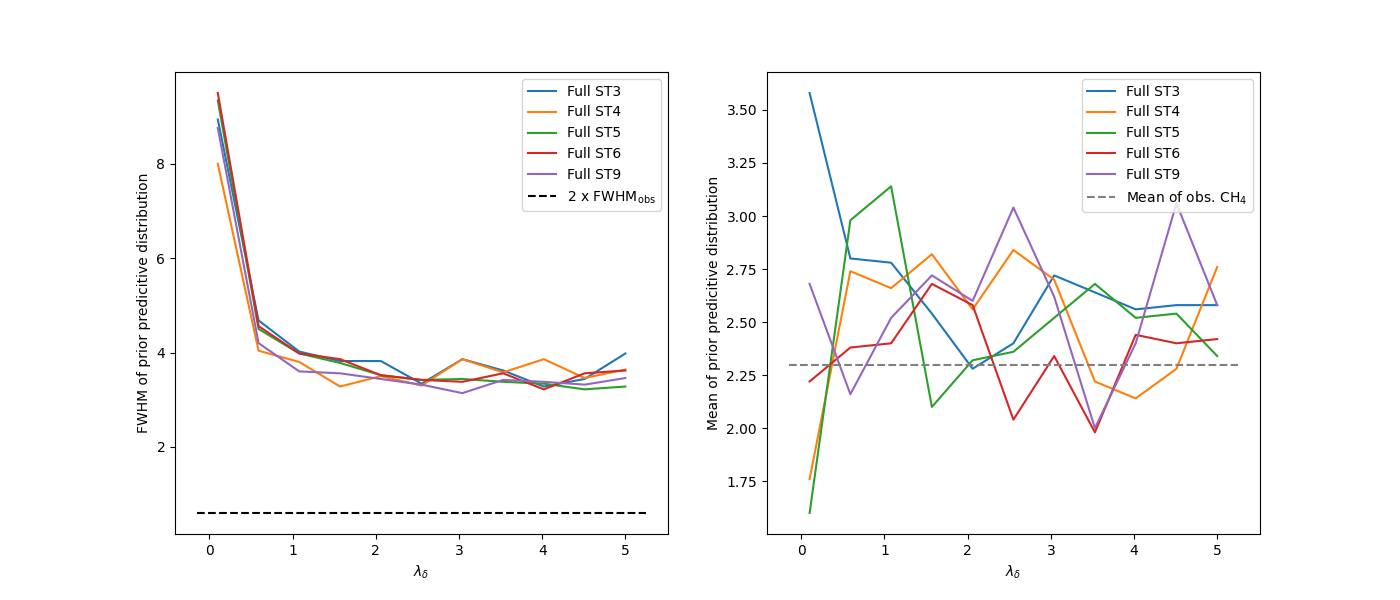

In [199]:
fig, axs = plt.subplots(figsize=(14,6), ncols=2)
axs = axs.flatten()
labels = ['Full ST3','Full ST4','Full ST5','Full ST6','Full ST9']
for i in range(len(labels)):
    axs[0].plot(lambda_deltas, fwhms_lambda_delta[i], label=labels[i])

xlims = axs[0].get_xlim()
axs[0].plot((xlims[0], xlims[1]),(2*fwhm_obs_ch4, 2*fwhm_obs_ch4), 'k--', label='2 x FWHM$_{\mathrm{obs}}$')
axs[0].legend()
axs[0].set_xlabel(r'$\lambda_{\delta}$')
axs[0].set_ylabel('FWHM of prior predicitive distribution')

for i in range(len(labels)):
    axs[1].plot(lambda_deltas, means_lambda_delta[i], label=labels[i])

xlims = axs[1].get_xlim()
axs[1].plot((xlims[0], xlims[1]),(mean_obs_ch4, mean_obs_ch4), '--', color='gray', label='Mean of obs. CH$_4$')
axs[1].legend()
axs[1].set_xlabel(r'$\lambda_{\delta}$')
axs[1].set_ylabel('Mean of prior predicitive distribution')

In [200]:
gamma_std = 2.0 #np.linspace(0.1,5,11)
lambda_beta = 1.0
lambda_delta = 1.0
lambda_epsilons = np.linspace(0.1, 5, 11)
fwhms_lambda_epsilon = [[], [], [], [], [], []]
means_lambda_epsilon = [[], [], [], [], [], []]
for i, lambda_epsilon in enumerate(lambda_epsilons):
    simple_ch4, idata_simple_ch4 = simple_model(T=data_ch4.T_air.values, y=data_ch4.F_CH4_ln.values, alpha_mean=ch4_tenC_mean, alpha_std=ch4_tenC_std,  lambda_beta=lambda_beta, lambda_epsilon=lambda_epsilon)
    # cover_ch4_st3, idata_cover_ch4_st3 = cover_model(T=data_ch4.T_air.values, X=st_3_ch4, y = data_ch4.F_CH4_ln.values, gamma_mu_mean=ch4_tenC_mean, gamma_mu_std=ch4_tenC_std, gamma_std=gamma_std, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    # cover_ch4_st5, idata_cover_ch4_st5 = cover_model(T=data_ch4.T_air.values, X=st_5_ch4, y = data_ch4.F_CH4_ln.values, gamma_mu_mean=ch4_tenC_mean, gamma_mu_std=ch4_tenC_std, gamma_std=gamma_std, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    # cover_ch4_st9, idata_cover_ch4_st9 = cover_model(T=data_ch4.T_air.values, X=st_9_ch4, y = data_ch4.F_CH4_ln.values, gamma_mu_mean=ch4_tenC_mean, gamma_mu_std=ch4_tenC_std, gamma_std=gamma_std, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    full_ch4_st3, idata_full_ch4_st3 = full_model(T=data_ch4.T_air.values, X=st_3_ch4, y = data_ch4.F_CH4_ln.values, alpha_mu_mean=ch4_tenC_mean, alpha_mu_std=ch4_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    full_ch4_st4, idata_full_ch4_st4 = full_model(T=data_ch4.T_air.values, X=st_4_ch4, y = data_ch4.F_CH4_ln.values, alpha_mu_mean=ch4_tenC_mean, alpha_mu_std=ch4_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    full_ch4_st5, idata_full_ch4_st5 = full_model(T=data_ch4.T_air.values, X=st_5_ch4, y = data_ch4.F_CH4_ln.values, alpha_mu_mean=ch4_tenC_mean, alpha_mu_std=ch4_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    full_ch4_st6, idata_full_ch4_st6 = full_model(T=data_ch4.T_air.values, X=st_6_ch4, y = data_ch4.F_CH4_ln.values, alpha_mu_mean=ch4_tenC_mean, alpha_mu_std=ch4_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
    full_ch4_st9, idata_full_ch4_st9 = full_model(T=data_ch4.T_air.values, X=st_9_ch4, y = data_ch4.F_CH4_ln.values, alpha_mu_mean=ch4_tenC_mean, alpha_mu_std=ch4_tenC_std, gamma_std=gamma_std, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)

    idatas = [idata_simple_ch4, idata_full_ch4_st3, idata_full_ch4_st4, idata_full_ch4_st5, idata_full_ch4_st6, idata_full_ch4_st9]
    models = [simple_ch4, full_ch4_st3, full_ch4_st4, full_ch4_st5, full_ch4_st6, full_ch4_st9]
    
    sts = [None, st_3_ch4, st_4_ch4, st_5_ch4, st_6_ch4, st_9_ch4]
    cover_or_full = [None, 'full','full','full','full','full']
    for j, idata in enumerate(idatas):
        prior = idata['prior']
        if sts[j] is None:
            data_inds = np.random.choice(simple_ch4['T_air'].eval().shape[0], size=2000)
            pp = {k:np.squeeze(v.to_numpy()) for k,v in prior.items()}
            prior_values = simple_model_eq(simple_ch4['T_air'].eval(), pp, data_inds)
        else:
            data_inds = np.random.choice(sts[j].shape[0], size=2000)
            pp = {k:np.squeeze(v.to_numpy()) for k,v in prior.items()}
            if cover_or_full[j]=='cover':
                print('There should not be cover model')
            elif cover_or_full[j]=='full':
                prior_values = full_model_eq(models[j]['T_air'].eval(), sts[j].values, pp, data_inds)   

        kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(prior_values.reshape(-1, 1))
        x = np.linspace(-100,100,10001).reshape(-1,1)
        kde_values = np.exp(kde.score_samples(x))
        fwhm_temp, mean_temp = FWHM(x, kde_values)
        fwhms_lambda_epsilon[j].append(fwhm_temp)
        means_lambda_epsilon[j].append(mean_temp)


Sampling: [alpha, beta, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs,

Text(0, 0.5, 'Mean of prior predicitive distribution')

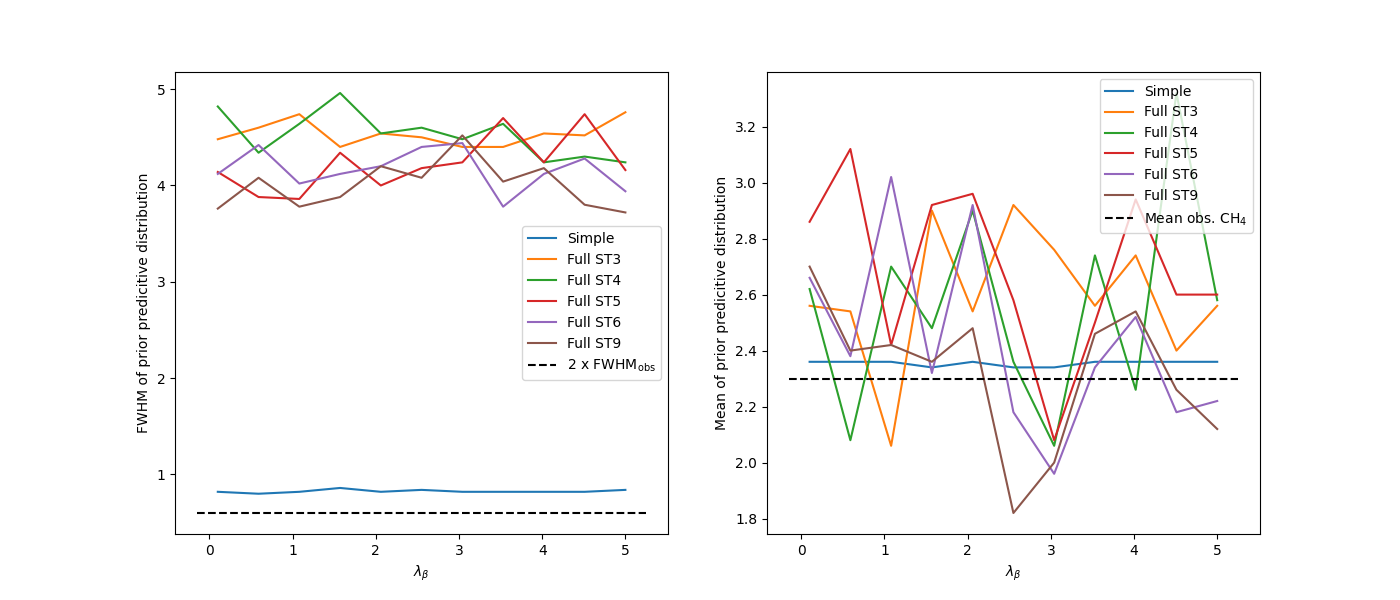

In [201]:
fig, axs = plt.subplots(figsize=(14,6), ncols=2)
axs = axs.flatten()

labels = ['Simple','Full ST3','Full ST4','Full ST5','Full ST6','Full ST9']
for i in range(len(labels)):
    axs[0].plot(lambda_epsilons, fwhms_lambda_epsilon[i], label=labels[i])

xlims = axs[0].get_xlim()
axs[0].plot((xlims[0], xlims[1]),(2*fwhm_obs_ch4, 2*fwhm_obs_ch4), 'k--', label='2 x FWHM$_{\mathrm{obs}}$')
axs[0].legend()
axs[0].set_xlabel(r'$\lambda_{\beta}$')
axs[0].set_ylabel('FWHM of prior predicitive distribution')

for i in range(len(labels)):
    axs[1].plot(lambda_epsilons, means_lambda_epsilon[i], label=labels[i])

xlims = axs[1].get_xlim()
axs[1].plot((xlims[0], xlims[1]),(mean_obs_ch4, mean_obs_ch4), 'k--', label='Mean obs. CH$_4$')
axs[1].legend()
axs[1].set_xlabel(r'$\lambda_{\beta}$')
axs[1].set_ylabel('Mean of prior predicitive distribution')

## Combine figures into one subplot

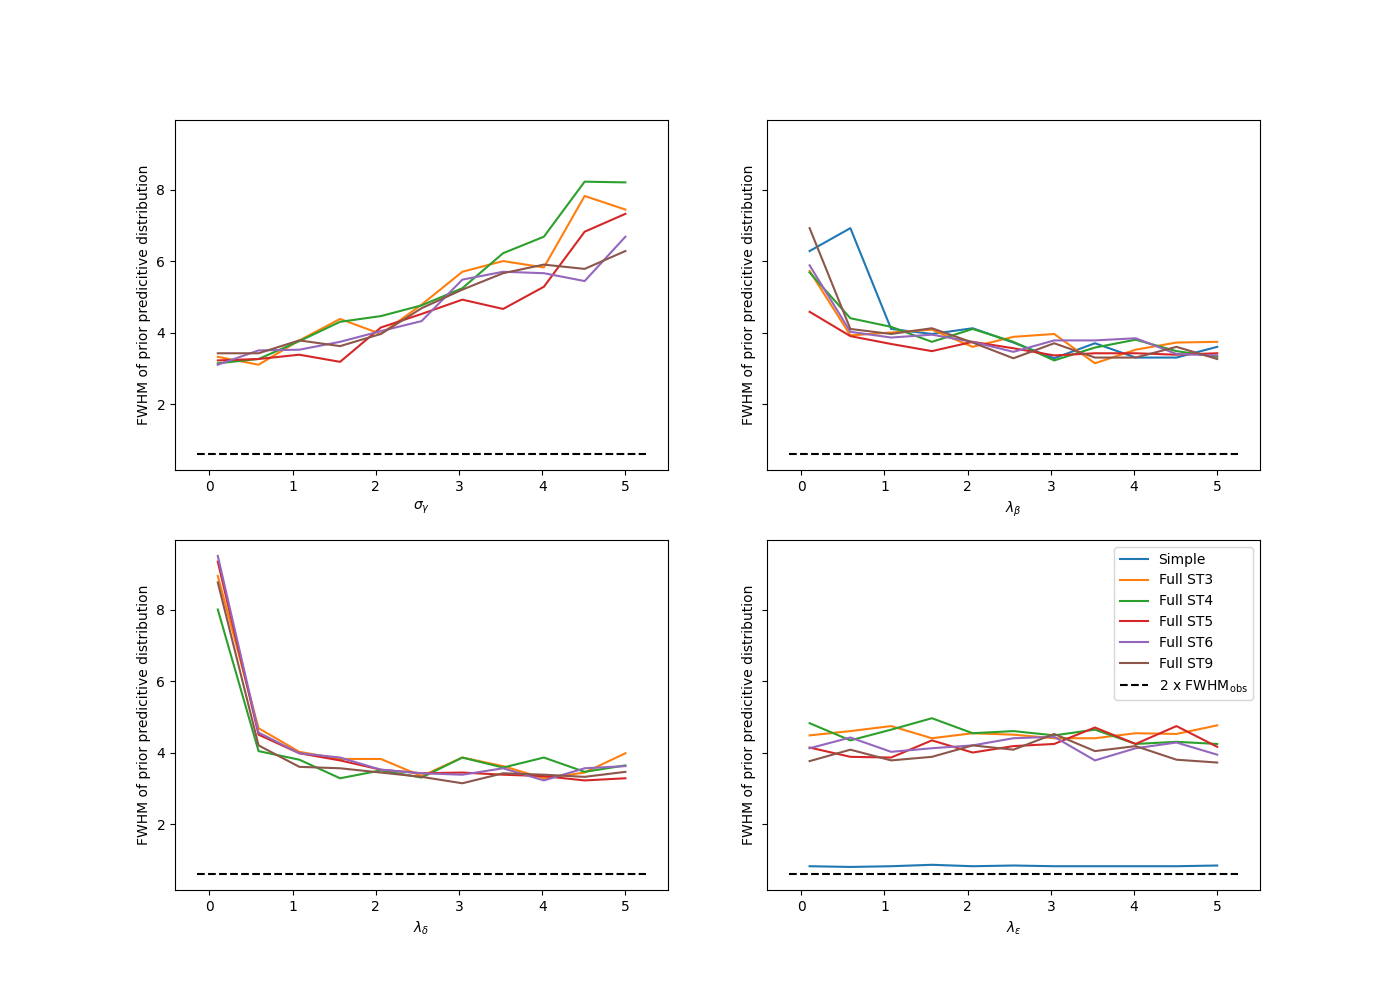

In [202]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14,10), sharey=True)
axs = axs.flatten()
labels = [['Full ST3','Full ST4','Full ST5','Full ST6','Full ST9'],
          ['Simple', 'Full ST3','Full ST4','Full ST5','Full ST6','Full ST9'],
          ['Full ST3','Full ST4','Full ST5','Full ST6','Full ST9'],
          ['Simple','Full ST3','Full ST4','Full ST5','Full ST6','Full ST9'],
          ]
default_colors = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])
colors = [default_colors[1:6],
          default_colors[:6],
          default_colors[1:7],
          default_colors[:7]]
fwhms = [fwhms_gamma_std, fwhms_lambda_beta, fwhms_lambda_delta, fwhms_lambda_epsilon]
xlabels = [r'$\sigma_{\gamma}$',r'$\lambda_{\beta}$',r'$\lambda_{\delta}$',r'$\lambda_{\epsilon}$']
x_axis_values = [gamma_stds, lambda_betas, lambda_deltas, lambda_epsilons]
for i, ax in enumerate(axs):
    for j in range(len(fwhms[i])):
        ax.plot(x_axis_values[i], fwhms[i][j], label=labels[i][j], color=colors[i][j])

    xlims = ax.get_xlim()
    ax.plot((xlims[0], xlims[1]),(2*fwhm_obs_ch4, 2*fwhm_obs_ch4), 'k--', label='2 x FWHM$_{\mathrm{obs}}$')
    if i==3:
        ax.legend()

    ax.set_xlabel(xlabels[i])
    ax.set_ylabel('FWHM of prior predicitive distribution')

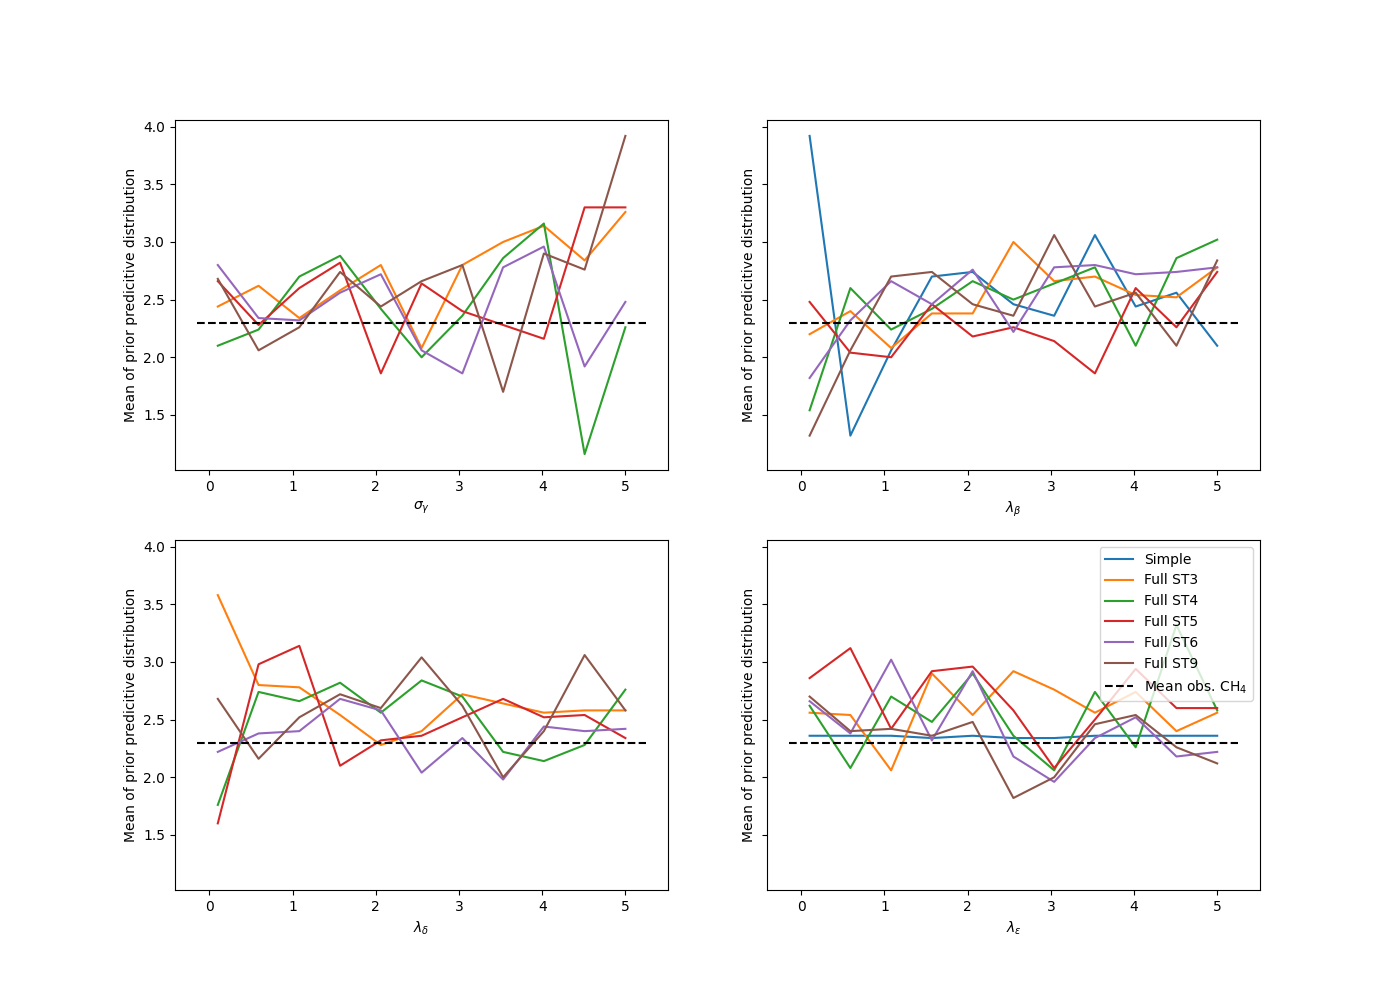

In [203]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14,10), sharey=True)
axs = axs.flatten()
labels = [['Full ST3','Full ST4','Full ST5','Full ST6','Full ST9'],
          ['Simple', 'Full ST3','Full ST4','Full ST5','Full ST6','Full ST9'],
          ['Full ST3','Full ST4','Full ST5','Full ST6','Full ST9'],
          ['Simple','Full ST3','Full ST4','Full ST5','Full ST6','Full ST9'],
          ]
default_colors = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])
colors = [default_colors[1:6],
          default_colors[:6],
          default_colors[1:7],
          default_colors[:7]]
means = [mean_gamma_std, means_lambda_beta, means_lambda_delta, means_lambda_epsilon]
xlabels = [r'$\sigma_{\gamma}$',r'$\lambda_{\beta}$',r'$\lambda_{\delta}$',r'$\lambda_{\epsilon}$']
x_axis_values = [gamma_stds, lambda_betas, lambda_deltas, lambda_epsilons]
for i, ax in enumerate(axs):
    for j in range(len(means[i])):
        ax.plot(x_axis_values[i], means[i][j], label=labels[i][j], color=colors[i][j])

    xlims = ax.get_xlim()
    ax.plot((xlims[0], xlims[1]),(mean_obs_ch4, mean_obs_ch4), 'k--', label='Mean obs. CH$_4$')
    if i==3:
        ax.legend()

    ax.set_xlabel(xlabels[i])
    ax.set_ylabel('Mean of prior predicitive distribution')

## Choose values
These values are used in the notebook [GHG_models_fit.ipynb](GHG_models_fit.ipynb)
$$
\begin{align*}
\sigma_\gamma = 2.0 \\
\lambda_\beta = 1.0 \\
\lambda_\delta = 1.0 \\
\lambda_\epsilon = 1.0
\end{align*}
$$

Sampling: [alpha, beta, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]
Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]


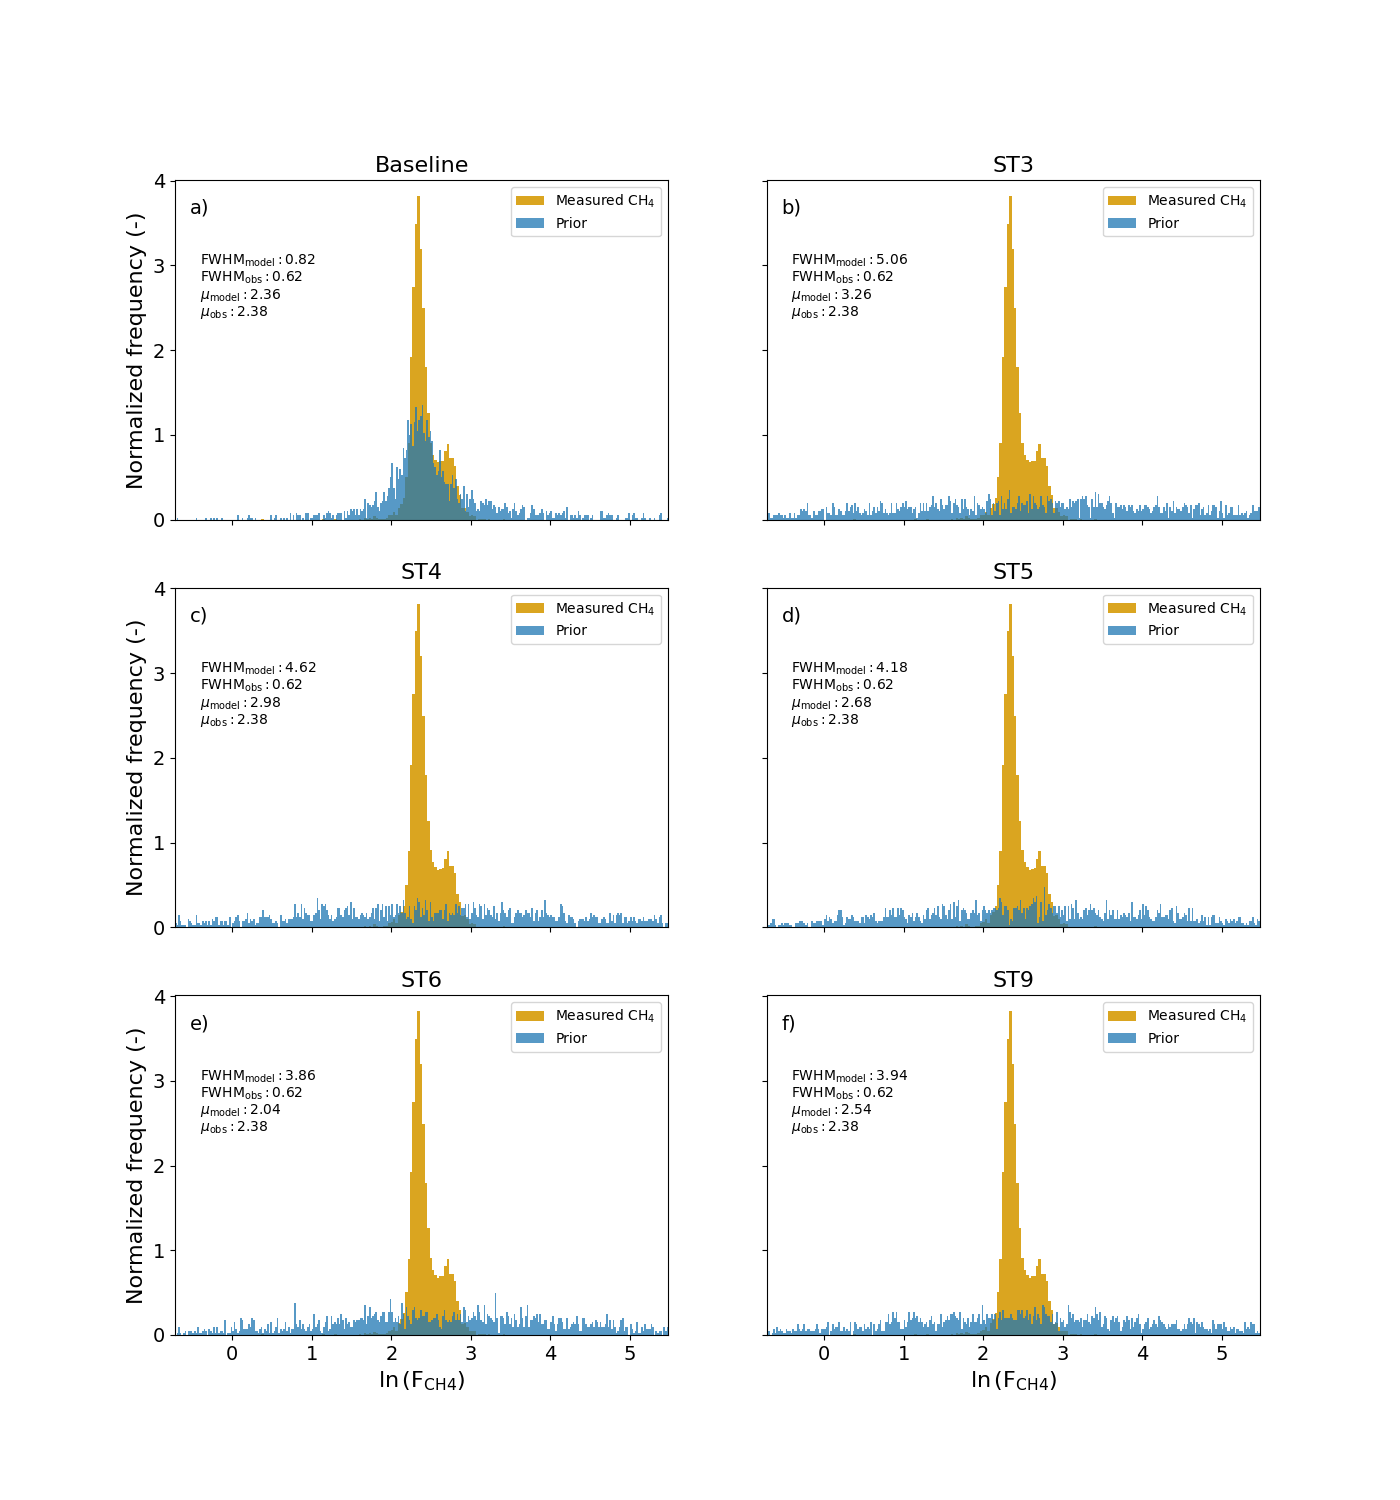

In [207]:
fig, axs = plt.subplots(figsize=(14,15), nrows=3, ncols=2, sharex=True, sharey=True)
axs = axs.flatten()
sigma_gamma = 2.0
lambda_beta = 1.0
lambda_delta = 1.0
lambda_epsilon=1.0

simple_ch4, idata_simple_ch4 = simple_model(T=data_ch4.T_air.values, y=data_ch4.F_CH4_ln.values, alpha_mean=ch4_tenC_mean, alpha_std=ch4_tenC_std,  lambda_beta=lambda_beta, lambda_epsilon=lambda_epsilon)
# cover_ch4_st3, idata_cover_ch4_st3 = cover_model(T=data_ch4.T_air.values, X=st_3_ch4, y = data_ch4.F_CH4_ln.values, gamma_mu_mean=ch4_tenC_mean, gamma_mu_std=ch4_tenC_std, gamma_std=sigma_gamma, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
# cover_ch4_st5, idata_cover_ch4_st5 = cover_model(T=data_ch4.T_air.values, X=st_5_ch4, y = data_ch4.F_CH4_ln.values, gamma_mu_mean=ch4_tenC_mean, gamma_mu_std=ch4_tenC_std, gamma_std=sigma_gamma, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
# cover_ch4_st9, idata_cover_ch4_st9 = cover_model(T=data_ch4.T_air.values, X=st_9_ch4, y = data_ch4.F_CH4_ln.values, gamma_mu_mean=ch4_tenC_mean, gamma_mu_std=ch4_tenC_std, gamma_std=sigma_gamma, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)

full_ch4_st3, idata_full_ch4_st3 = full_model(T=data_ch4.T_air.values, X=st_3_ch4, y = data_ch4.F_CH4_ln.values, alpha_mu_mean=ch4_tenC_mean, alpha_mu_std=ch4_tenC_std, gamma_std=sigma_gamma, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
full_ch4_st4, idata_full_ch4_st4 = full_model(T=data_ch4.T_air.values, X=st_4_ch4, y = data_ch4.F_CH4_ln.values, alpha_mu_mean=ch4_tenC_mean, alpha_mu_std=ch4_tenC_std, gamma_std=sigma_gamma, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
full_ch4_st5, idata_full_ch4_st5 = full_model(T=data_ch4.T_air.values, X=st_5_ch4, y = data_ch4.F_CH4_ln.values, alpha_mu_mean=ch4_tenC_mean, alpha_mu_std=ch4_tenC_std, gamma_std=sigma_gamma, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
full_ch4_st6, idata_full_ch4_st6 = full_model(T=data_ch4.T_air.values, X=st_6_ch4, y = data_ch4.F_CH4_ln.values, alpha_mu_mean=ch4_tenC_mean, alpha_mu_std=ch4_tenC_std, gamma_std=sigma_gamma, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)
full_ch4_st9, idata_full_ch4_st9 = full_model(T=data_ch4.T_air.values, X=st_9_ch4, y = data_ch4.F_CH4_ln.values, alpha_mu_mean=ch4_tenC_mean, alpha_mu_std=ch4_tenC_std, gamma_std=sigma_gamma, lambda_beta=lambda_beta, lambda_delta=lambda_delta, lambda_epsilon=lambda_epsilon)

idatas = [idata_simple_ch4, idata_full_ch4_st3, idata_full_ch4_st4, idata_full_ch4_st5, idata_full_ch4_st6, idata_full_ch4_st9]
models = [simple_ch4, full_ch4_st3, full_ch4_st4, full_ch4_st5, full_ch4_st6, full_ch4_st9]
sts = [None, st_3_ch4, st_4_ch4, st_5_ch4, st_6_ch4, st_9_ch4]
full_or_cover = [None, 'full','full', 'full', 'full','full']
titles = ['Baseline','ST3','ST4','ST5','ST6','ST9']
subplot_labels = ['a)','b)','c)','d)','e)','f)']
for i, idata in enumerate(idatas):
    prior = idata['prior']
    if sts[i] is None:
        data_inds = np.random.choice(simple_ch4['T_air'].eval().shape[0], size=2000)
        pp = {k:np.squeeze(v.to_numpy()) for k,v in prior.items()}
        prior_values = simple_model_eq(simple_ch4['T_air'].eval(), pp, data_inds)
    else:
        data_inds = np.random.choice(sts[i].shape[0], size=2000)
        pp = {k:np.squeeze(v.to_numpy()) for k,v in prior.items()}
        if full_or_cover[i] == 'cover':
            print('There should not be a cover model')
        elif full_or_cover[i] == 'full':
            prior_values = full_model_eq(models[i]['T_air'].eval(), sts[i].values, pp, data_inds)

    plot_prior_predictive(obs_ch4, prior_values, 'CH$_4$', ax=axs[i], title=titles[i])

    if i==4 or i==5:
        axs[i].set_xlabel('$\ln{(\mathrm{F}_\mathrm{CH4})}$', fontsize=16)
    if i==0 or i==2 or i==4:
        axs[i].set_ylabel('Normalized frequency (-)', fontsize=16)
    axs[i].text(0.03, 0.9, subplot_labels[i], transform=axs[i].transAxes, fontsize=14)
    

# for ax in axs[-2:]:
#     ax.remove()

## Choose values
For simplicity, use same values for both gases. These values are used in the notebook [GHG_models_fit.ipynb](GHG_models_fit.ipynb)
$$
\begin{align*}
\sigma_\gamma = 2.0 \\
\lambda_\beta = 1.0 \\
\lambda_\delta = 1.0 \\
\lambda_\epsilon = 1.0
\end{align*}
$$